In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy

from jax import random


import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from scipy import integrate

import time

from jax.numpy import fft

from tqdm import tqdm

In [2]:
from jax import jit, grad, vmap, hessian, value_and_grad
import optax

In [3]:
# Define the neural network
def init_params(layer_sizes, key):
    params = []
    keys = random.split(key, len(layer_sizes))
    for m, n, key in zip(layer_sizes[:-1], layer_sizes[1:], keys):
        weights = random.normal(key, (m, n)) * jnp.sqrt(2 / m)
        biases = jnp.zeros(n)
        params.append((weights, biases))
    return params

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

In [4]:
def count_parameters(params):
    total_params = 0
    for weights, biases in params:
        total_params += weights.size
        total_params += biases.size
    return total_params

In [5]:
def compute_1d_error(pred, u, x, y):
    norm_u = jnp.sqrt(integrate.trapezoid(u**2, x))
    norm_diff = jnp.sqrt(integrate.trapezoid((pred - u)**2, x))
    return norm_diff, norm_diff/norm_u

In [14]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform, compute_sine_coefficients

# Using the DST for solving an elliptic PDE

We will solve the elliptic PDE with Dirichlet bc
\begin{aligned}
-\nu\Delta u + u &= \xi \\
u &= 0
\end{aligned}


If 
$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Then 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty  \Big(\nu\frac{n^2\pi^2}{L^2} + 1\Big)c_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

Conversely, if 
$$
\xi =  \sqrt{\frac{2}{L}} \sum_{i}^\infty \xi_i \sin\Big(\frac{n\pi x}{L}\Big)
$$

then 

$$
u =  \sqrt{\frac{2}{L}}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{n^2\pi^2}{L^2} + 1\Big)} \sin\Big(\frac{n\pi x}{L}\Big)
$$

In our case we will have the domain be $[0,1]$ and so $L = 1.0$. Therefore

\begin{aligned}
\xi &=   \sqrt{2} \sum_{i}^\infty \xi_i \sin\Big(i\pi x\Big) \\
u &=  \sqrt{2}\sum_{i}^\infty \frac{\xi_i}{(\nu\frac{i^2\pi^2}{L^2} + 1\Big)}\sin\Big(i\pi x\Big)
\end{aligned}

Our solution will be found using a NN.


In [6]:
plt.style.use('plot_style-Examples.txt')
#plt.style.use('default')

# 16:9 aspect ratio
width = 4
height = width * 3 / 4

In [7]:
from importlib import reload
import utils_DST

utils_DST = reload(utils_DST)
from utils_DST import discrete_sine_transform

In [8]:
key = random.PRNGKey(635)
nu = 0.01


n_coef = 2**14
upper = 1.0
lower = 0.0
boundary = jnp.array([lower, upper])
boundary_conditions = jnp.array([0.0, 0.0])

domain_finest = jnp.linspace(lower,upper,n_coef+1, endpoint=False)[1:] # Do not include 0 or 1!
print(n_coef)

frequencies = jnp.arange(0, n_coef) + 1
coef_f = jnp.hstack([random.normal(key, shape= (n_coef,))])
coef_u = coef_f/(nu*frequencies**2*jnp.pi**2 + 1)

f_values = discrete_sine_transform(coef_f)
u_values = discrete_sine_transform(coef_u)

16384


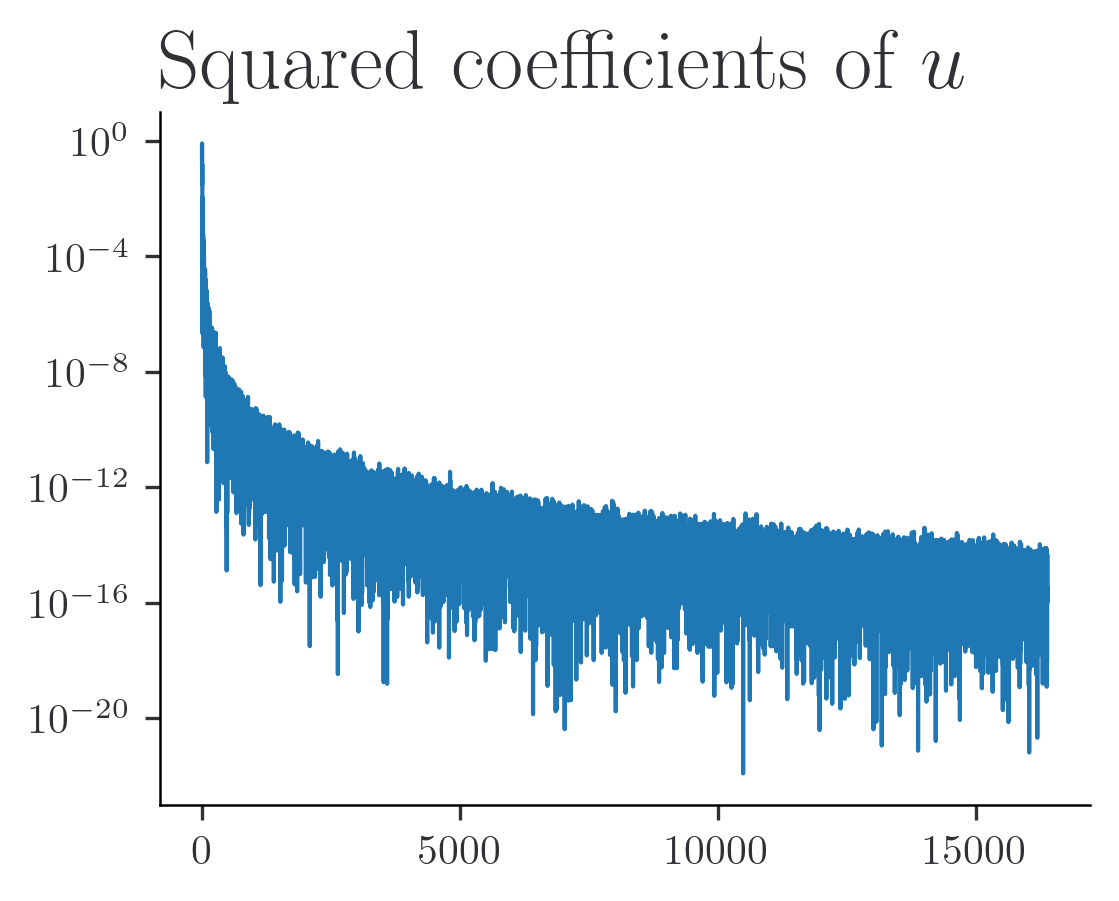

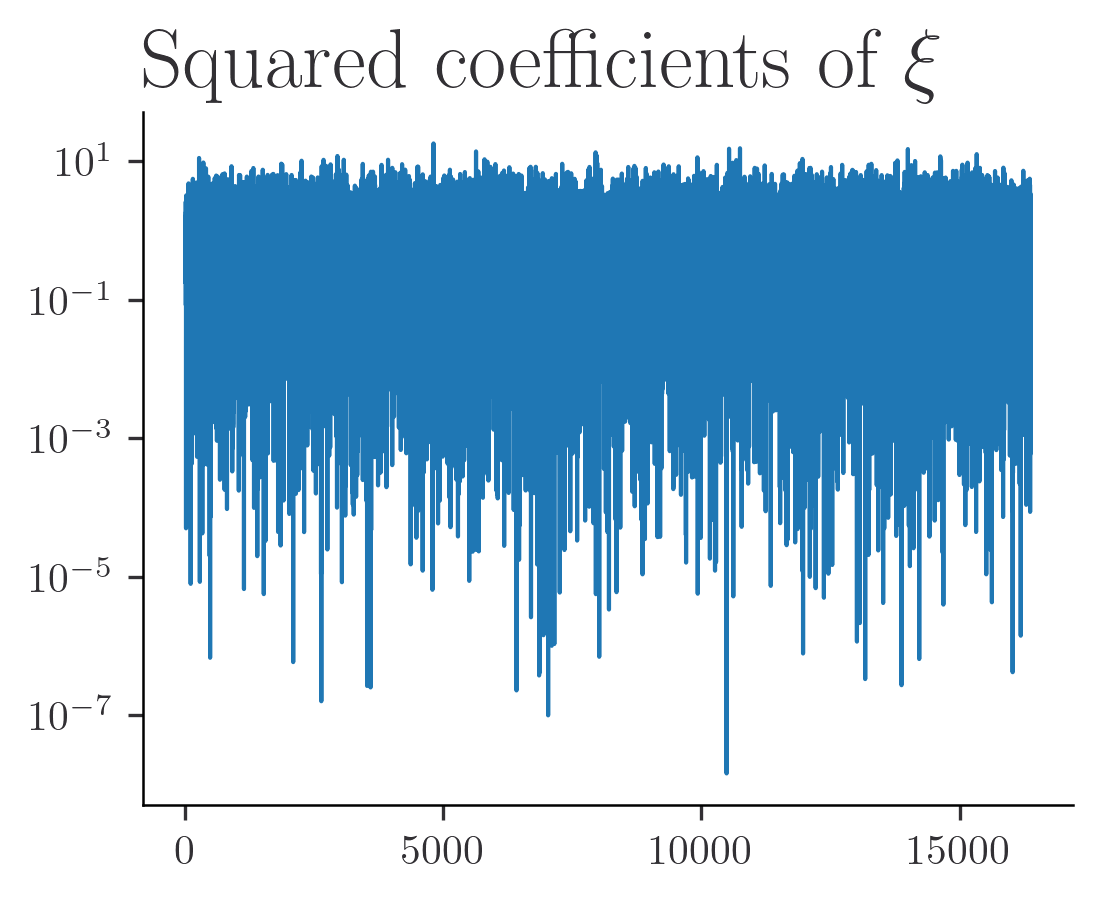

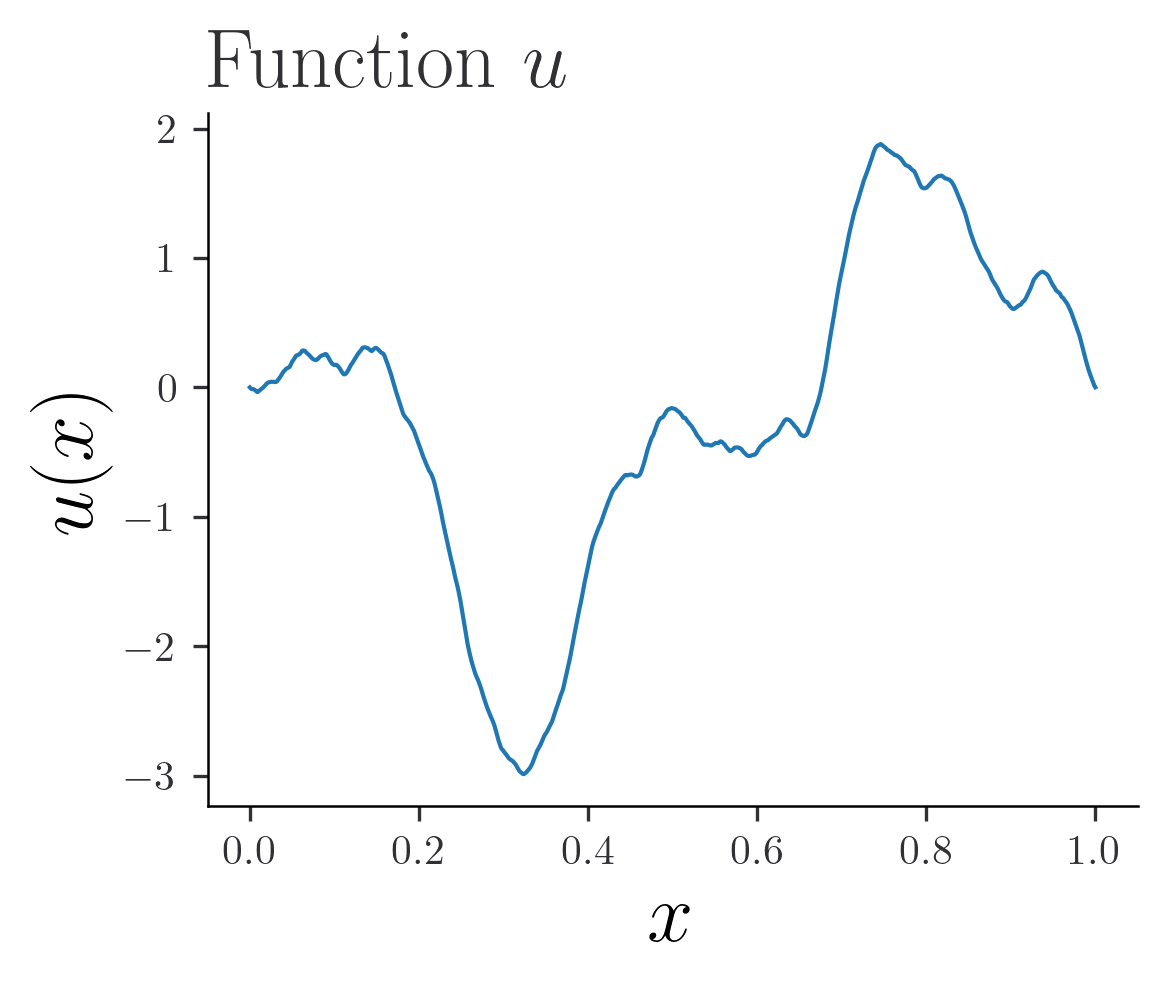

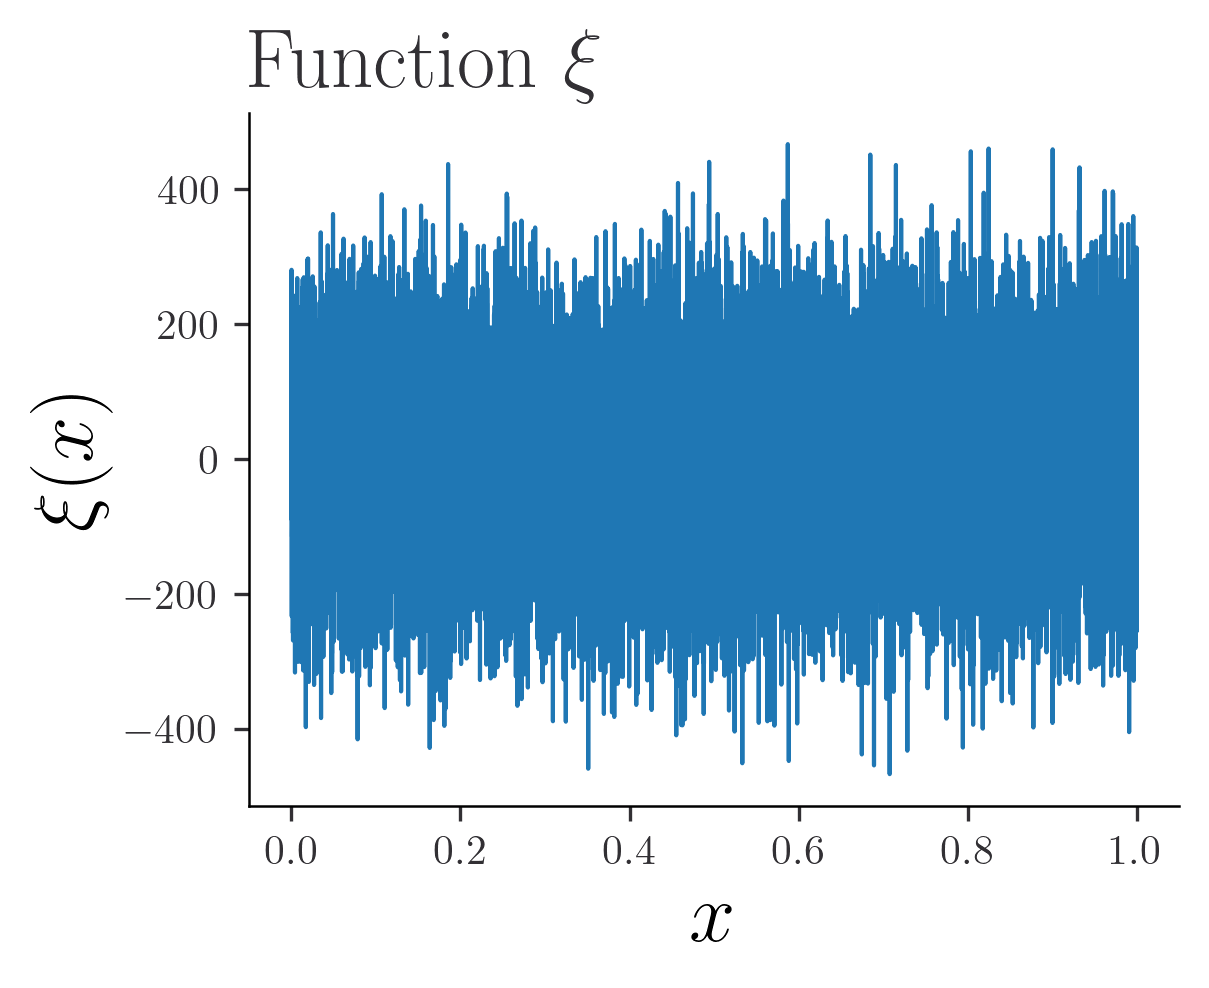

In [9]:
# Plot both the coeffients of u and f in 2 subplots
fig = plt.figure(figsize=(width, height))
plt.plot(coef_u**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $u$')


plt.show()

fig = plt.figure(figsize=(width, height))
plt.plot(coef_f**2)
plt.yscale('log')
plt.title(r'Squared coefficients of $\xi$')
plt.show()

# Create 2 plots for the  function u and f
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, u_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")

fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, f_values)
plt.xlabel(r"$x$")
plt.ylabel(r"$\xi(x)$")
plt.title(r"Function $\xi$")

plt.gca().autoscale()  # This applies to the current axis

plt.show()

# PINN 4096 measurements (unweighted norm)

In [16]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [17]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [20]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [21]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.2834959610802894 [(Array([[-6.75586185e-02, -6.98330962e-04,  1.30448892e-02,
        -1.76949760e-04, -3.58124946e-02, -1.38316625e-02,
        -2.55166238e-02,  2.34126802e-01,  4.33071423e-02,
        -1.51196850e-02, -1.09920438e-01,  2.95652056e-02,
        -1.75641995e-04, -2.59586935e-01, -1.17292707e-01,
        -2.10646967e-02, -2.87191406e-04,  1.73835519e-02,
        -9.70288358e-02, -5.72385228e-02,  4.85047669e-02,
         2.18344561e-02, -1.98503995e-01, -5.09899692e-03,
         1.77432520e-01, -1.97303041e-03,  7.18171277e-03,
         1.88725730e-01,  6.25826493e-04,  8.64494990e-02,
         7.67087337e-02, -1.70369381e-02]], dtype=float64), Array([-6.75455074e-02, -7.03009032e-04,  1.30467511e-02, -1.80345191e-04,
       -3.58179517e-02, -1.38363398e-02, -2.55000847e-02,  2.34113569e-01,
        4.32970171e-02, -1.51268076e-02, -1.09920616e-01,  2.95794154e-02,
       -1.77784378e-04, -2.59576405e-01, -1.17276683e-01, -2.10594094e-02,
       

In [22]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [23]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [27]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.2834960
Step 0, Training Loss: 1.2834960, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9748585
Step 10000, Training Loss: 0.9748585, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9660549
Step 20000, Training Loss: 0.9660549, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9645601
Step 30000, Training Loss: 0.9645601, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9613743
Step 40000, Training Loss: 0.9613743, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9597968
Step 50000, Training Loss: 0.9597968, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9588262
Step 60000, Training Loss: 0.9588262, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9583673
Step 70000, Training Loss: 0.9583673, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9558730
Step 80000, Training Loss: 0.9558730, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9556716
Step 90000, Training Loss: 0.9556716, Learning Rate: 0.000387


In [29]:
pred = neural_network(params, domain_finest)

In [33]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.1117128996508573 0.08976654874324214


In [34]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.1117129, dtype=float64), Array(0.08976655, dtype=float64))

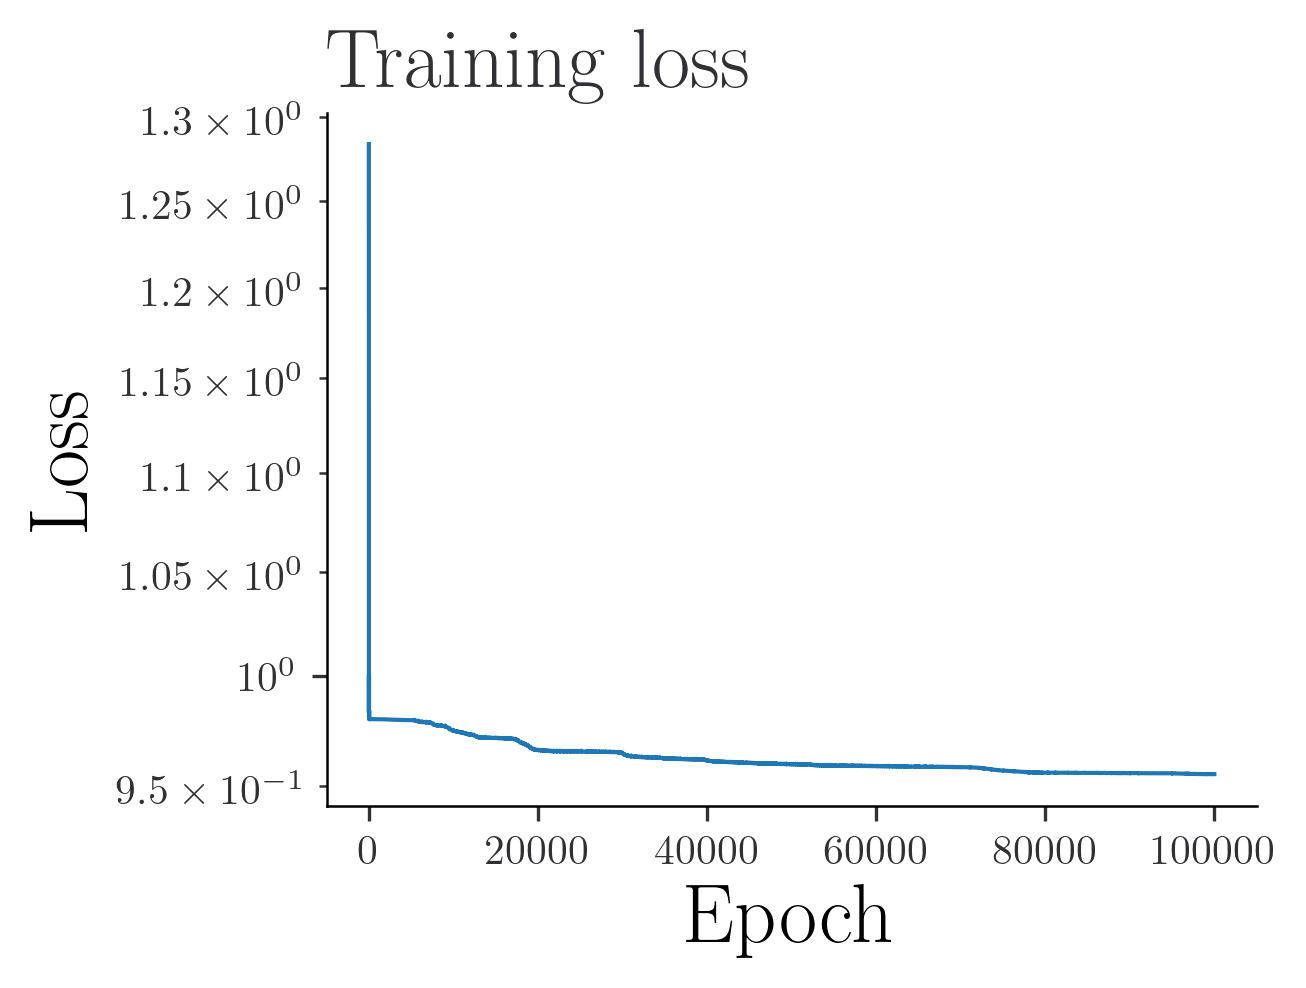

In [35]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

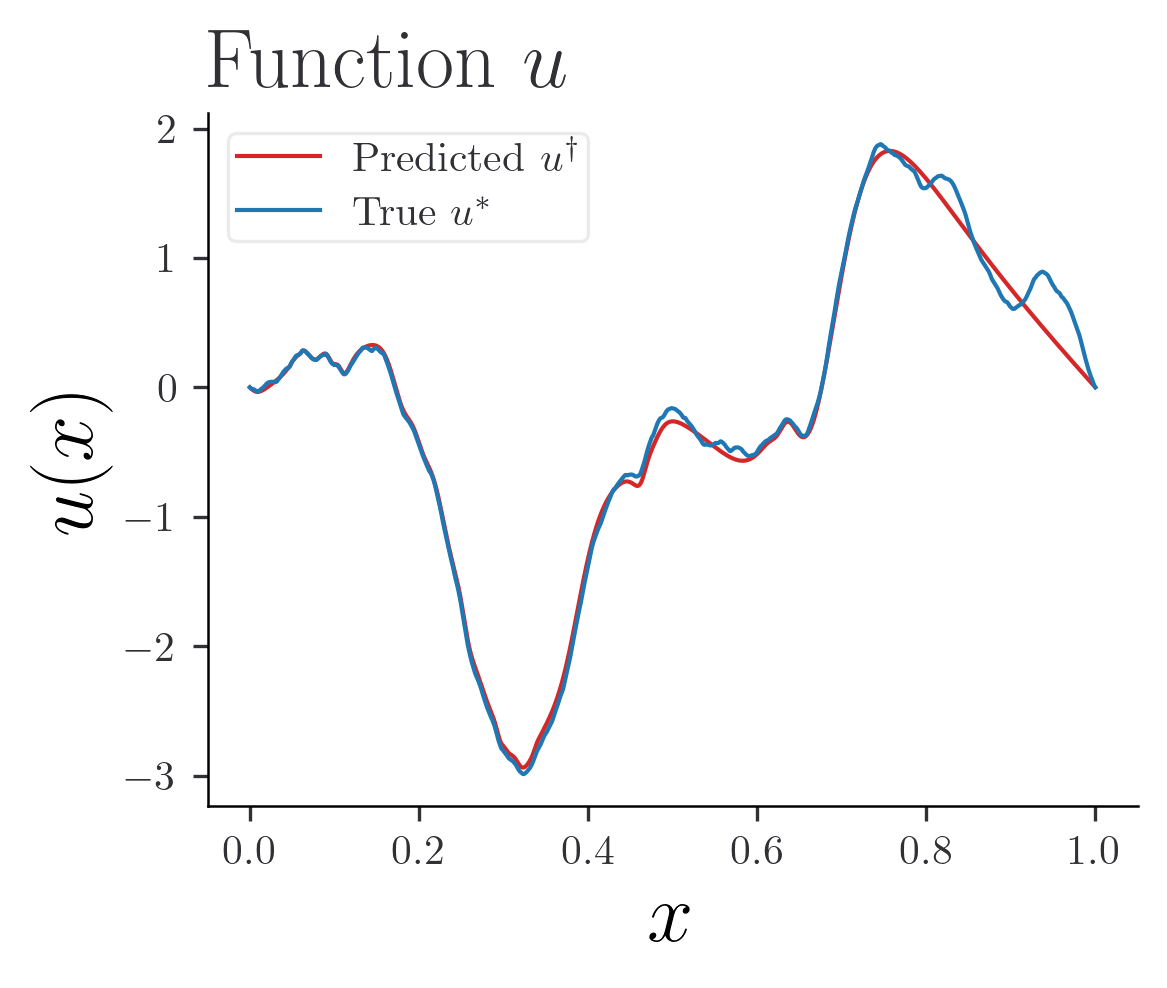

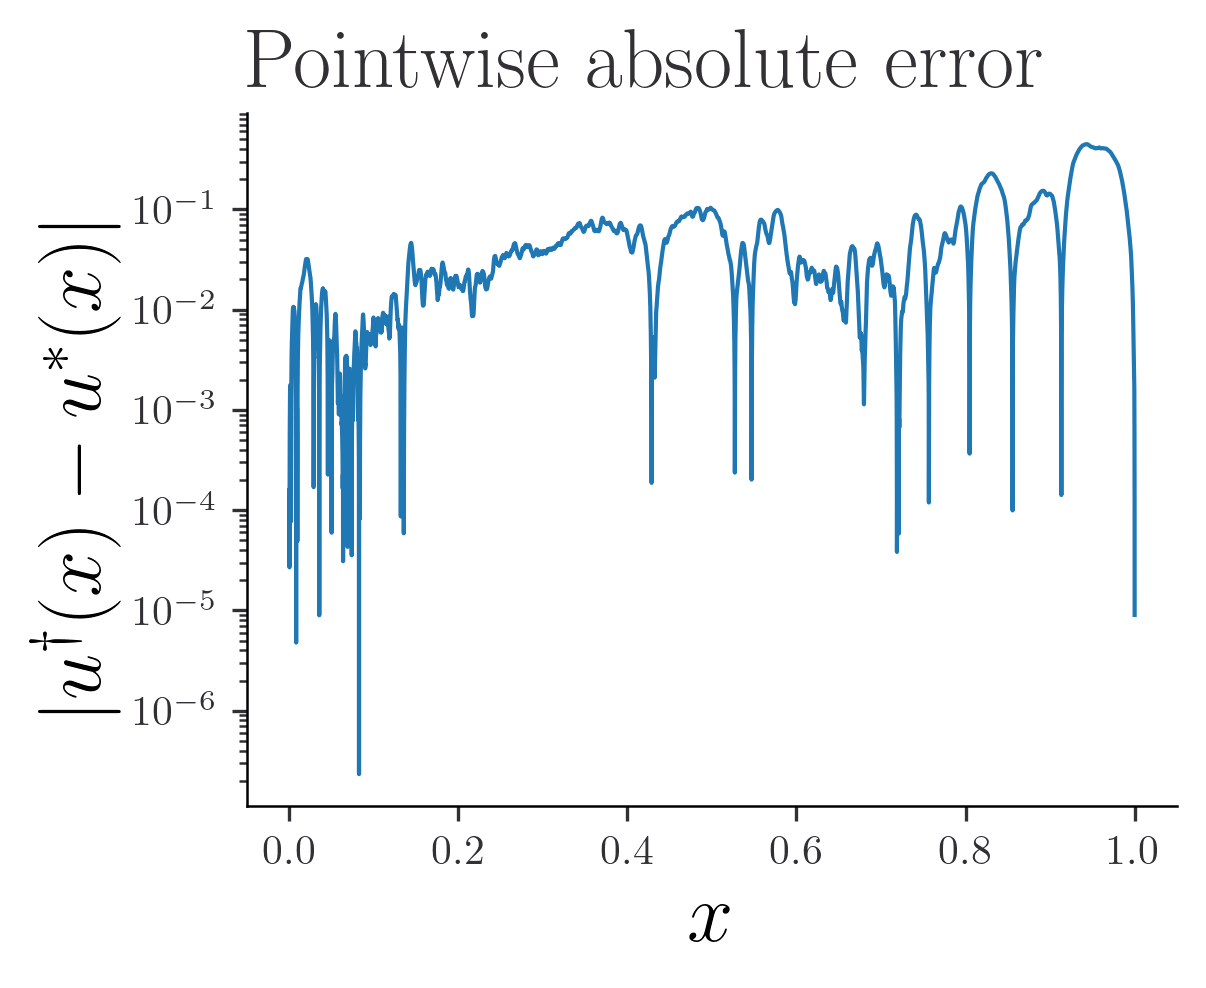

In [36]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


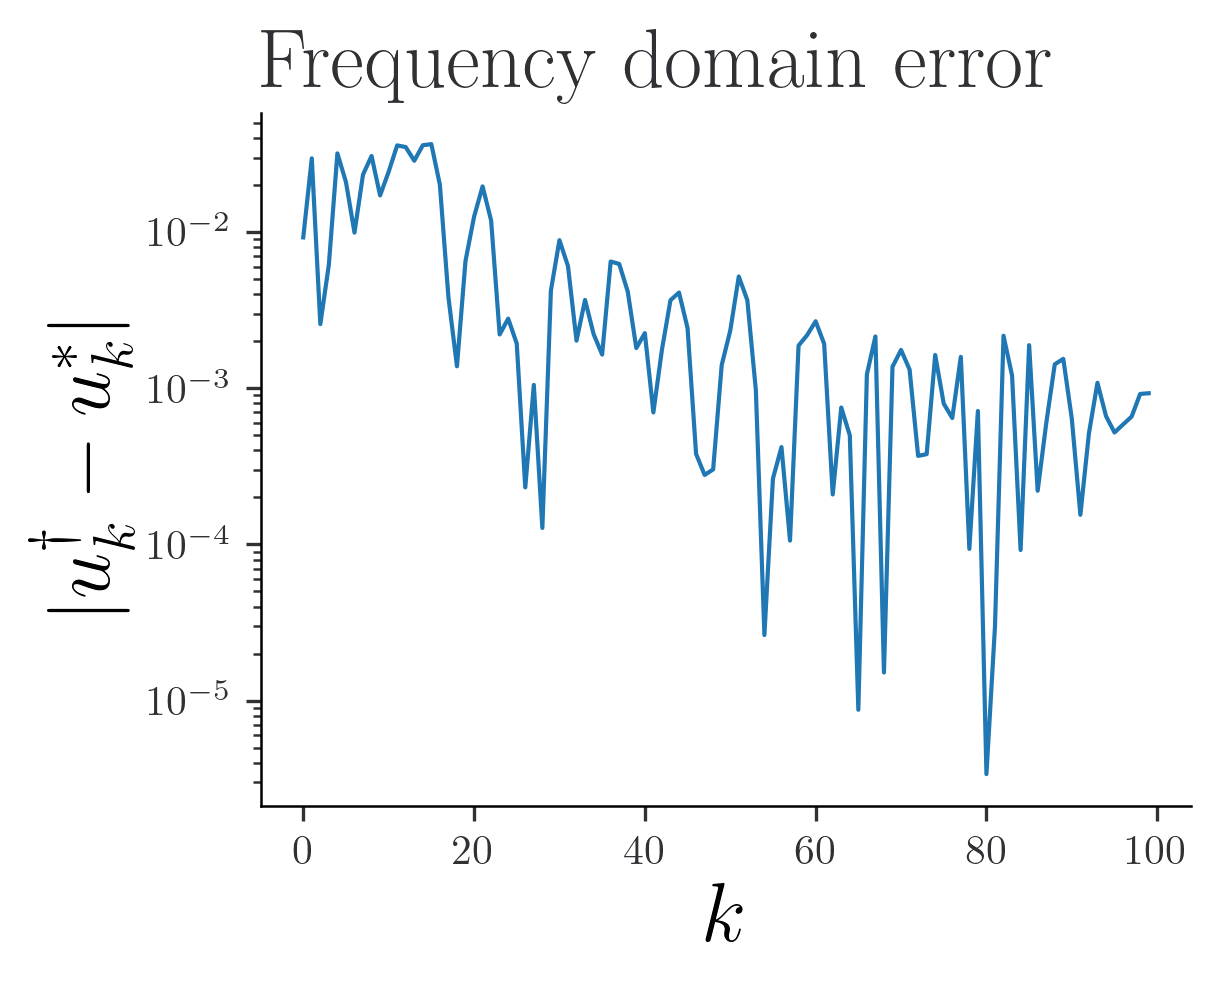

In [37]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

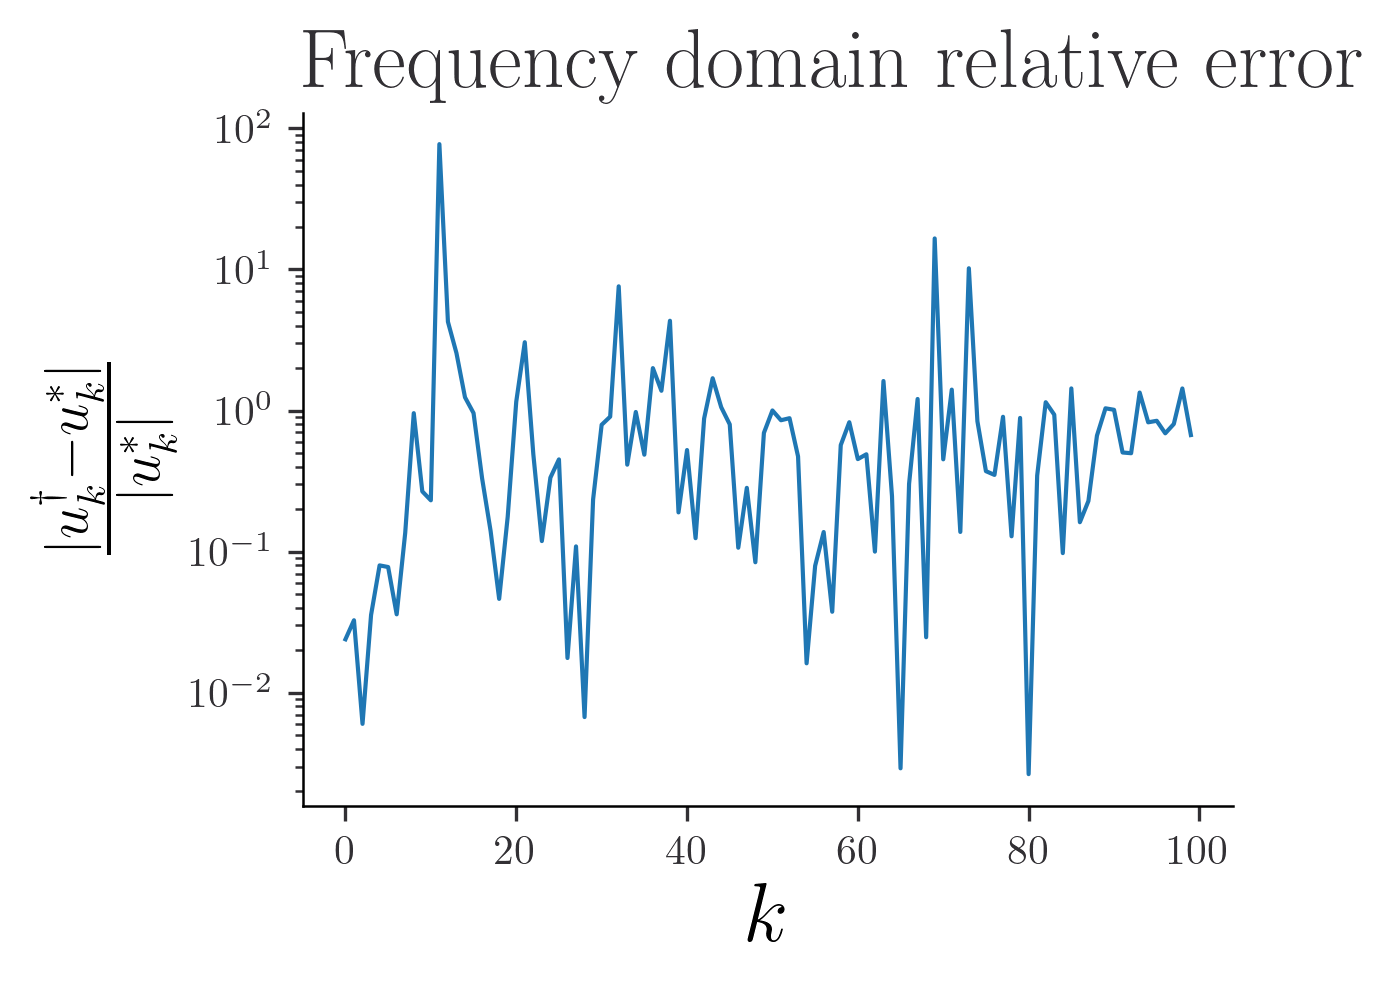

In [38]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# Medium PINN 4096 measurements (unweighted norm)

In [10]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [11]:
layer_sizes = [1, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 4353 parameters in the neural network.


In [12]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [15]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.5001707554545771 [(Array([[ 7.98264166e-02,  1.86711341e-02, -7.33122868e-02,
        -1.39489495e-02, -8.08290822e-02, -1.27037271e-01,
         2.22561562e-01, -7.35700222e-03,  1.37783662e-02,
         4.85196405e-03,  2.35390875e-02, -5.70014633e-03,
        -1.24145298e-02,  3.15489389e-02, -4.52498683e-02,
        -5.79029892e-02, -4.40838410e-02, -2.75151815e-01,
         1.31219630e-01,  4.99221386e-02,  1.70510779e-01,
         7.18174175e-03,  6.04607523e-02,  5.22031910e-02,
         1.18949150e-03, -2.55848134e-01, -7.38258696e-03,
        -1.21809425e-03, -7.83566090e-02, -8.88642298e-03,
         3.00403510e-02,  8.35079649e-02, -9.63776009e-02,
        -8.57843454e-02,  3.87074634e-03, -3.82135981e-02,
         1.21857359e-01,  2.00858877e-01,  2.28454435e-02,
        -8.49500951e-02, -2.33052112e-04, -4.00694262e-02,
        -1.88895611e-01, -1.08684118e-02, -1.73375167e-03,
         1.32988067e-01,  7.24547026e-02, -1.05022151e-01,
        -1.35

In [16]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [17]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [18]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.5001708
Step 0, Training Loss: 1.5001708, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9752635
Step 10000, Training Loss: 0.9752635, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9706357
Step 20000, Training Loss: 0.9706357, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9637094
Step 30000, Training Loss: 0.9637094, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9569859
Step 40000, Training Loss: 0.9569859, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9525181
Step 50000, Training Loss: 0.9525181, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9502466
Step 60000, Training Loss: 0.9502466, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9498314
Step 70000, Training Loss: 0.9498314, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9487950
Step 80000, Training Loss: 0.9487950, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9477712
Step 90000, Training Loss: 0.9477712, Learning Rate: 0.000387


In [19]:
pred = neural_network(params, domain_finest)

In [20]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.1279945543148497 0.1028496210794161


In [21]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.12799455, dtype=float64), Array(0.10284962, dtype=float64))

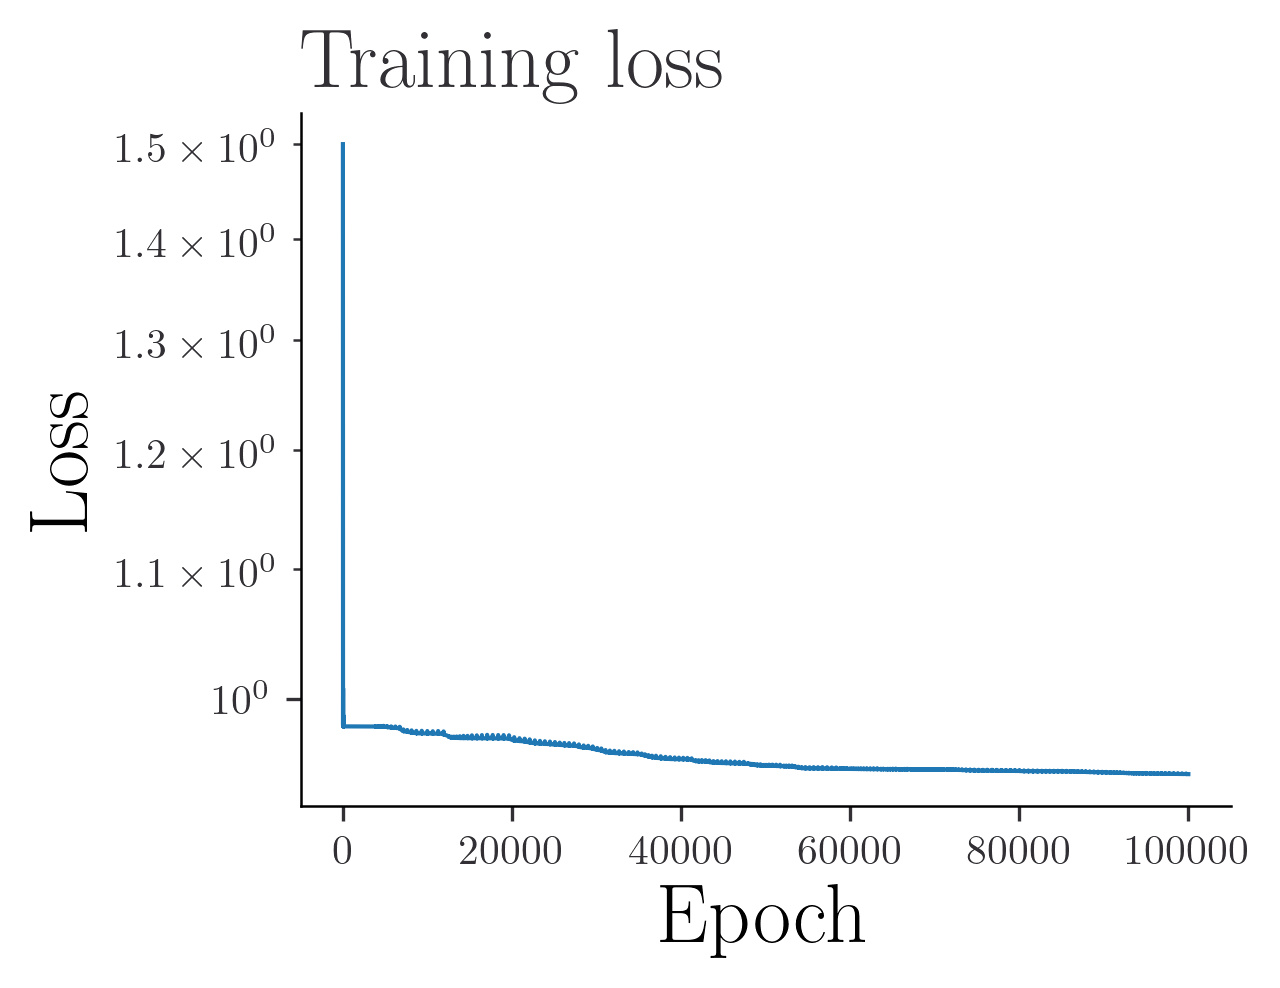

In [22]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

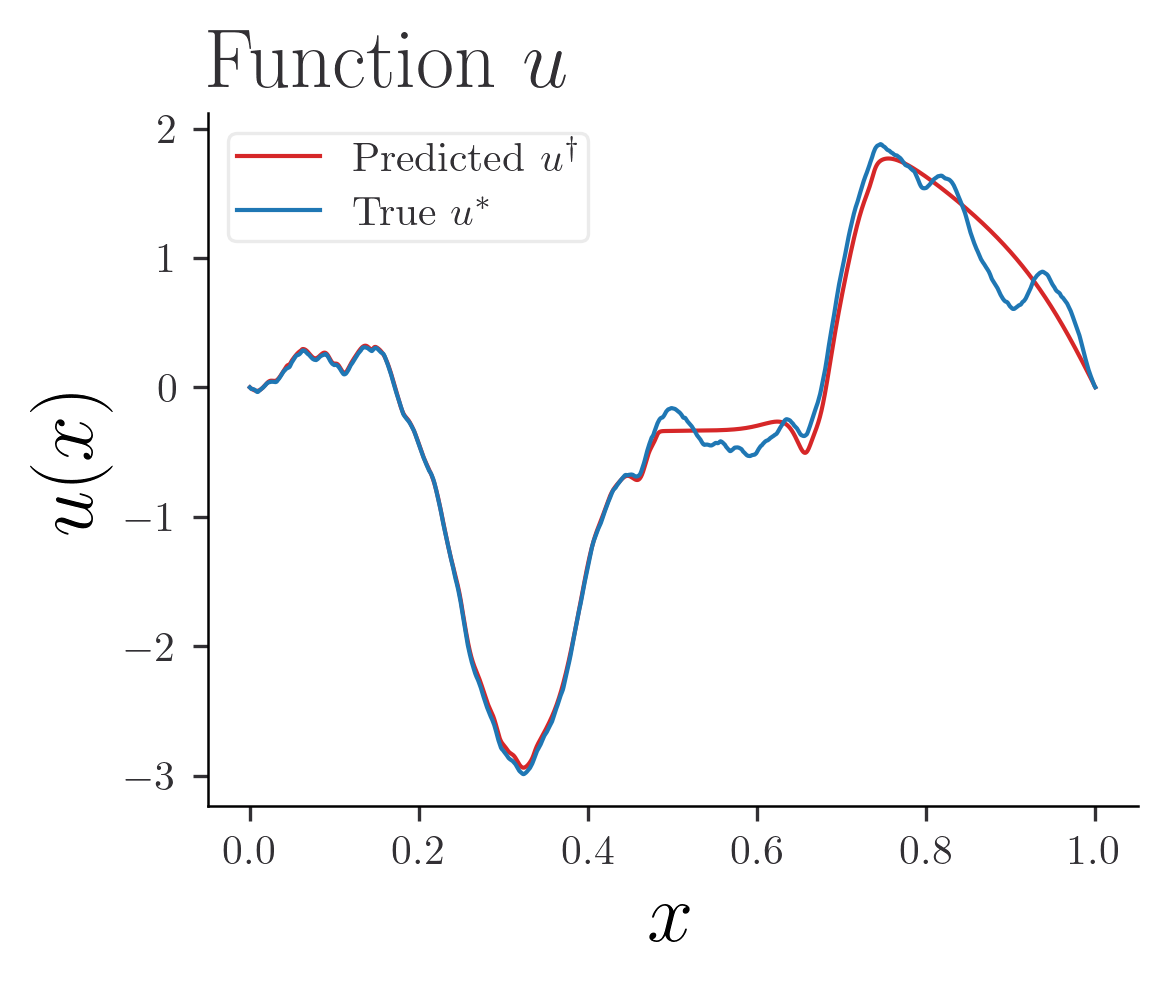

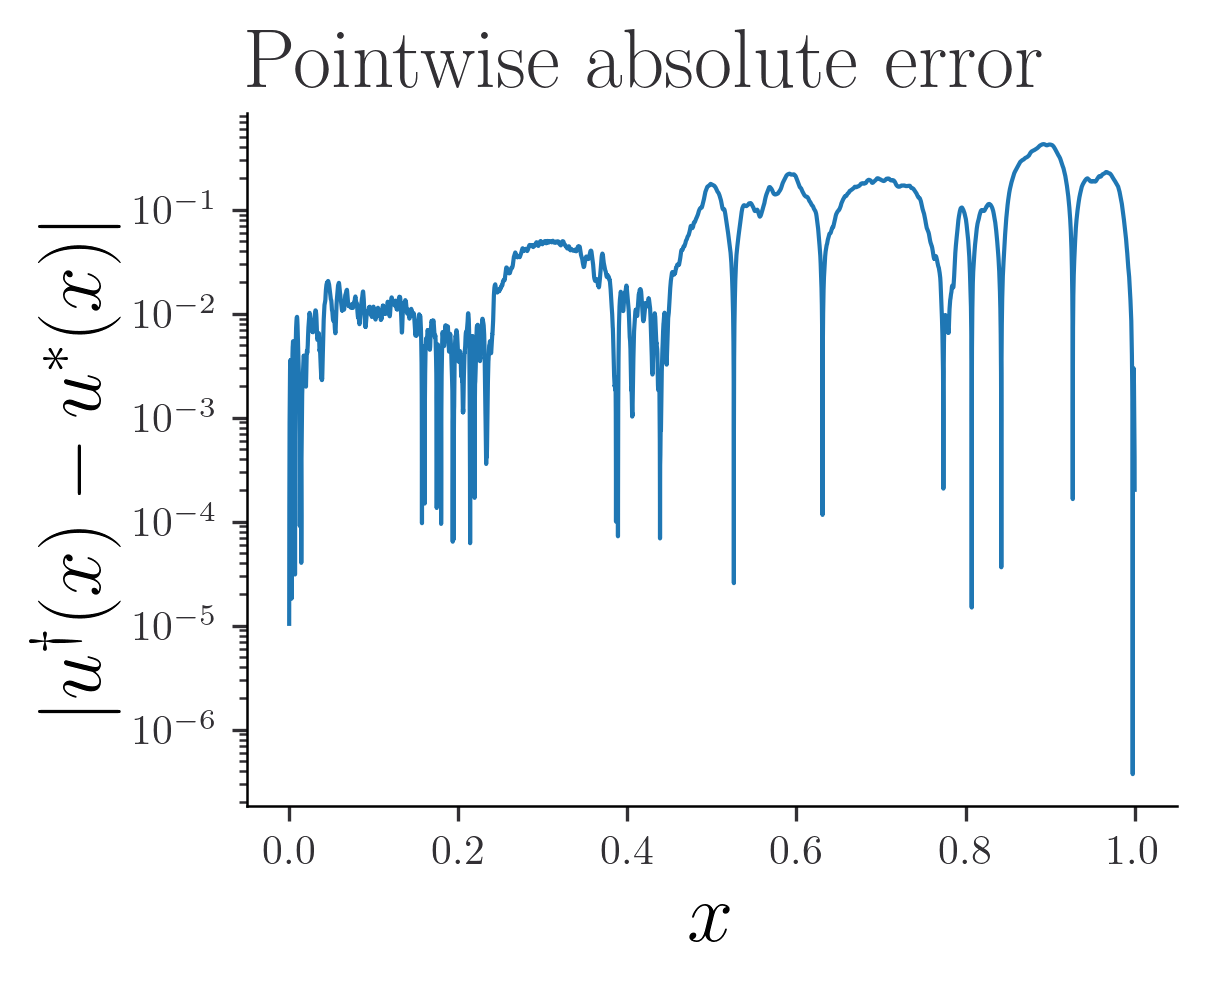

In [23]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


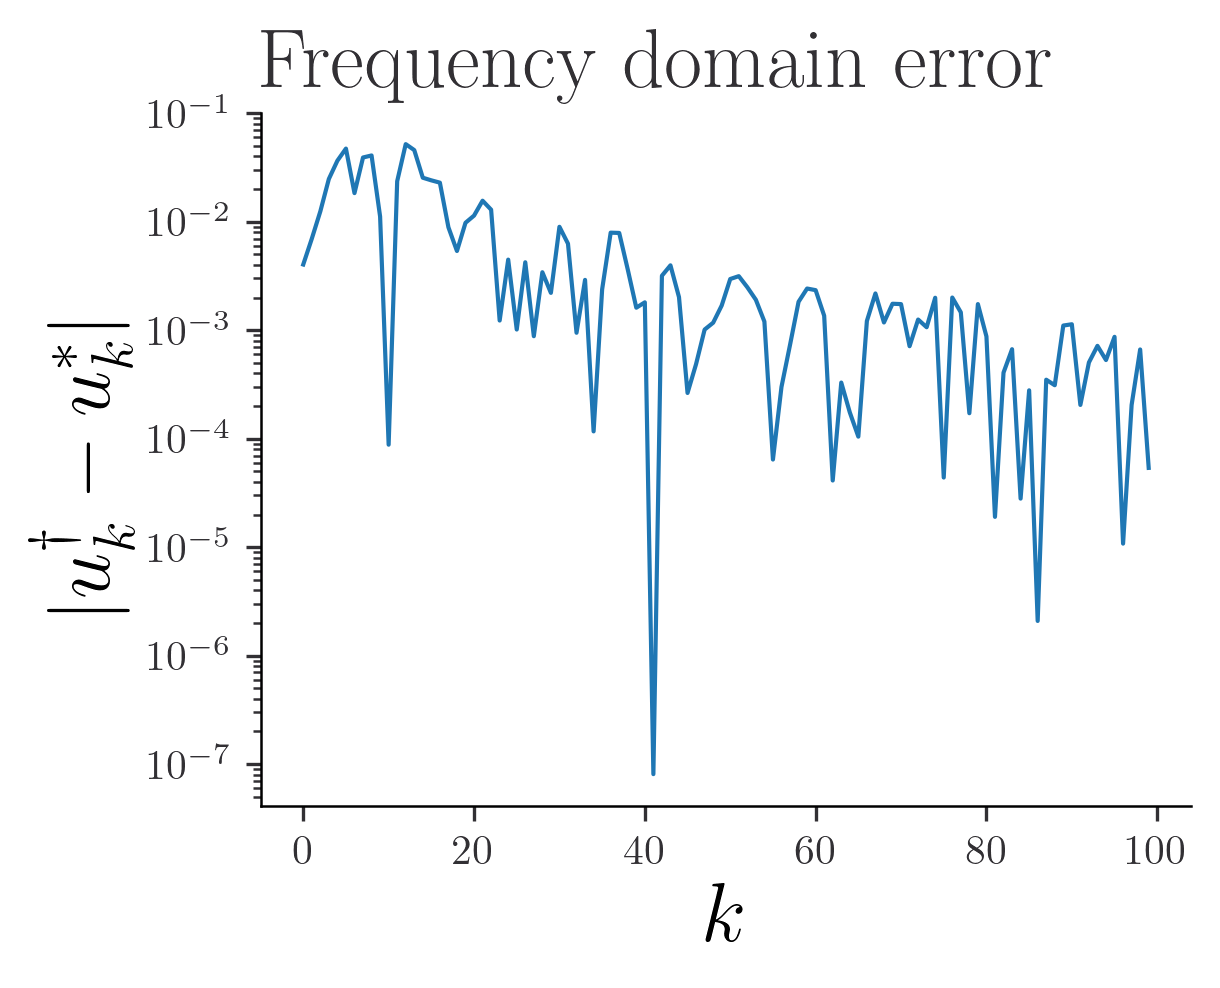

In [24]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

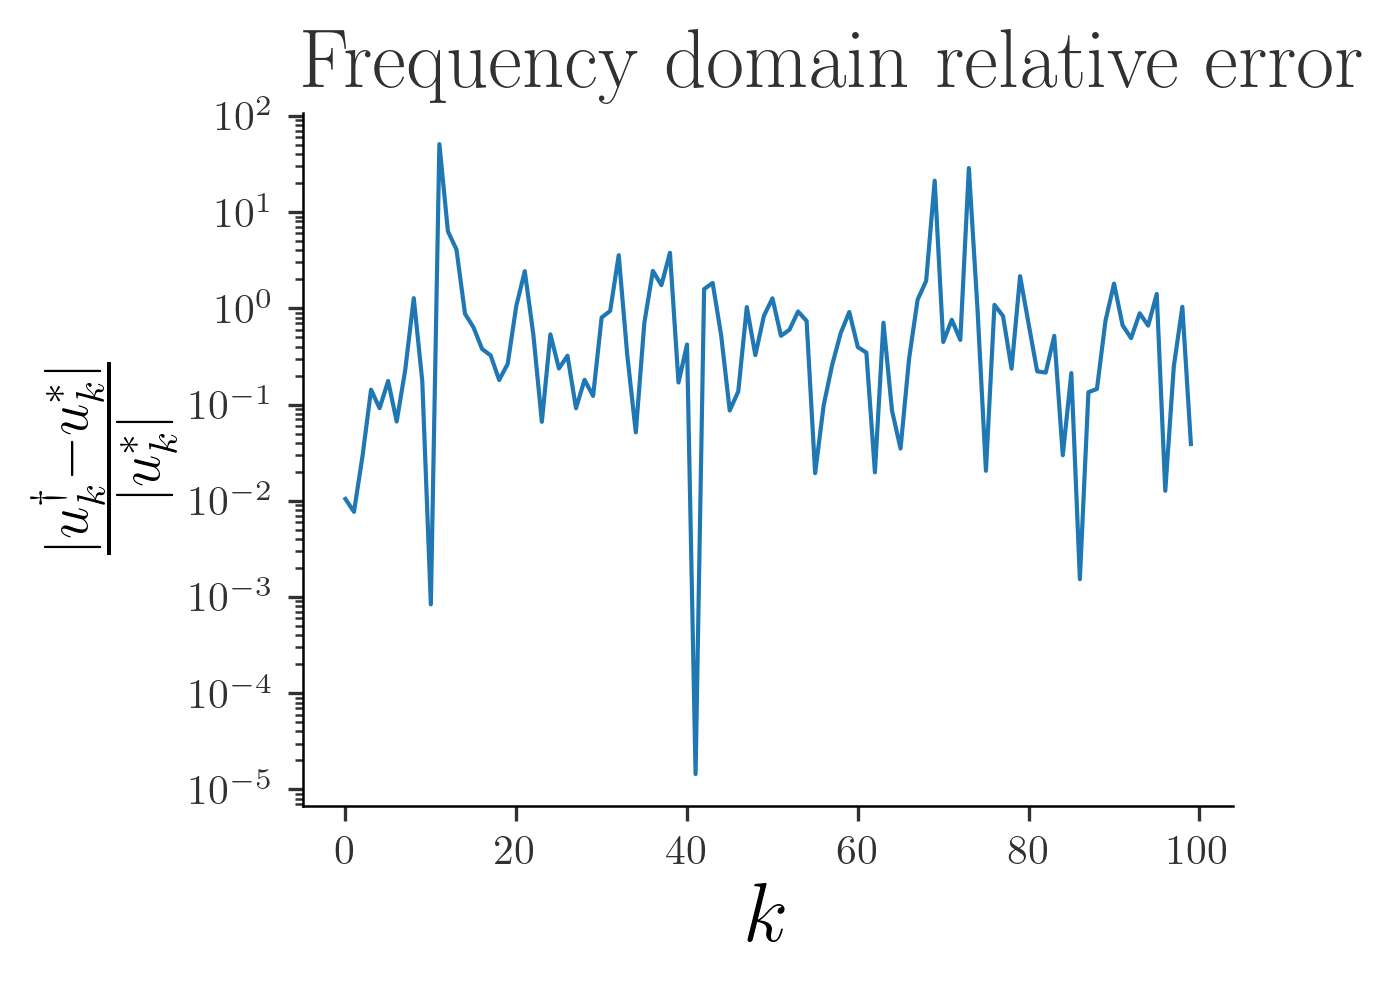

In [25]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

In [26]:
decay = jnp.arange(1, n_meas+1)**(-0.5)
decay

Array([1.        , 0.70710678, 0.57735027, ..., 0.01562882, 0.01562691,
       0.015625  ], dtype=float64, weak_type=True)

# Large PINN 4096 measurements (unweighted norm)

In [102]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [108]:
layer_sizes = [1, 64, 64, 64,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))

def predict(params, x):
    activations = x
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 8513 parameters in the neural network.


In [109]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [110]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.134503726710935 [(Array([[ 0.03493376,  0.01237922,  0.02779005,  0.06810632,  0.07729507,
         0.02241578, -0.00336038,  0.0002621 ,  0.01137738,  0.05700583,
        -0.00141467,  0.01824025,  0.01025343,  0.03515703, -0.04244149,
        -0.00666451, -0.04215559, -0.01380442,  0.02675143, -0.00038614,
         0.12358767, -0.02267214,  0.00646918,  0.00993463,  0.02827172,
         0.06697748, -0.02396474,  0.01016501,  0.02692946, -0.01097013,
        -0.00880884, -0.01713225,  0.01386318, -0.00890978, -0.00785356,
         0.00331591,  0.00498936, -0.0079386 , -0.05390575,  0.09122783,
        -0.0047352 , -0.02742659, -0.00792977, -0.03119489,  0.03973499,
         0.02275305, -0.02348128,  0.00968908,  0.01422539,  0.05182559,
        -0.05198763,  0.02952971, -0.00088247,  0.00306832,  0.00157133,
        -0.00342378,  0.03031892, -0.0173967 ,  0.12093071,  0.00203839,
        -0.002359  , -0.06849478, -0.06183854, -0.05867986]],      dtype=float64),

In [111]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [112]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [113]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.1345037
Step 0, Training Loss: 1.1345037, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9713158
Step 10000, Training Loss: 0.9713158, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9663654
Step 20000, Training Loss: 0.9663654, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9635917
Step 30000, Training Loss: 0.9635917, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9602596
Step 40000, Training Loss: 0.9602596, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9595674
Step 50000, Training Loss: 0.9595674, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9543264
Step 60000, Training Loss: 0.9543264, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9517560
Step 70000, Training Loss: 0.9517560, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9484334
Step 80000, Training Loss: 0.9484334, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9469640
Step 90000, Training Loss: 0.9469640, Learning Rate: 0.000387


In [114]:
pred = neural_network(params, domain_finest)

In [115]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

1.2272217806765346 0.9861301974809419


In [116]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(1.22722178, dtype=float64), Array(0.9861302, dtype=float64))

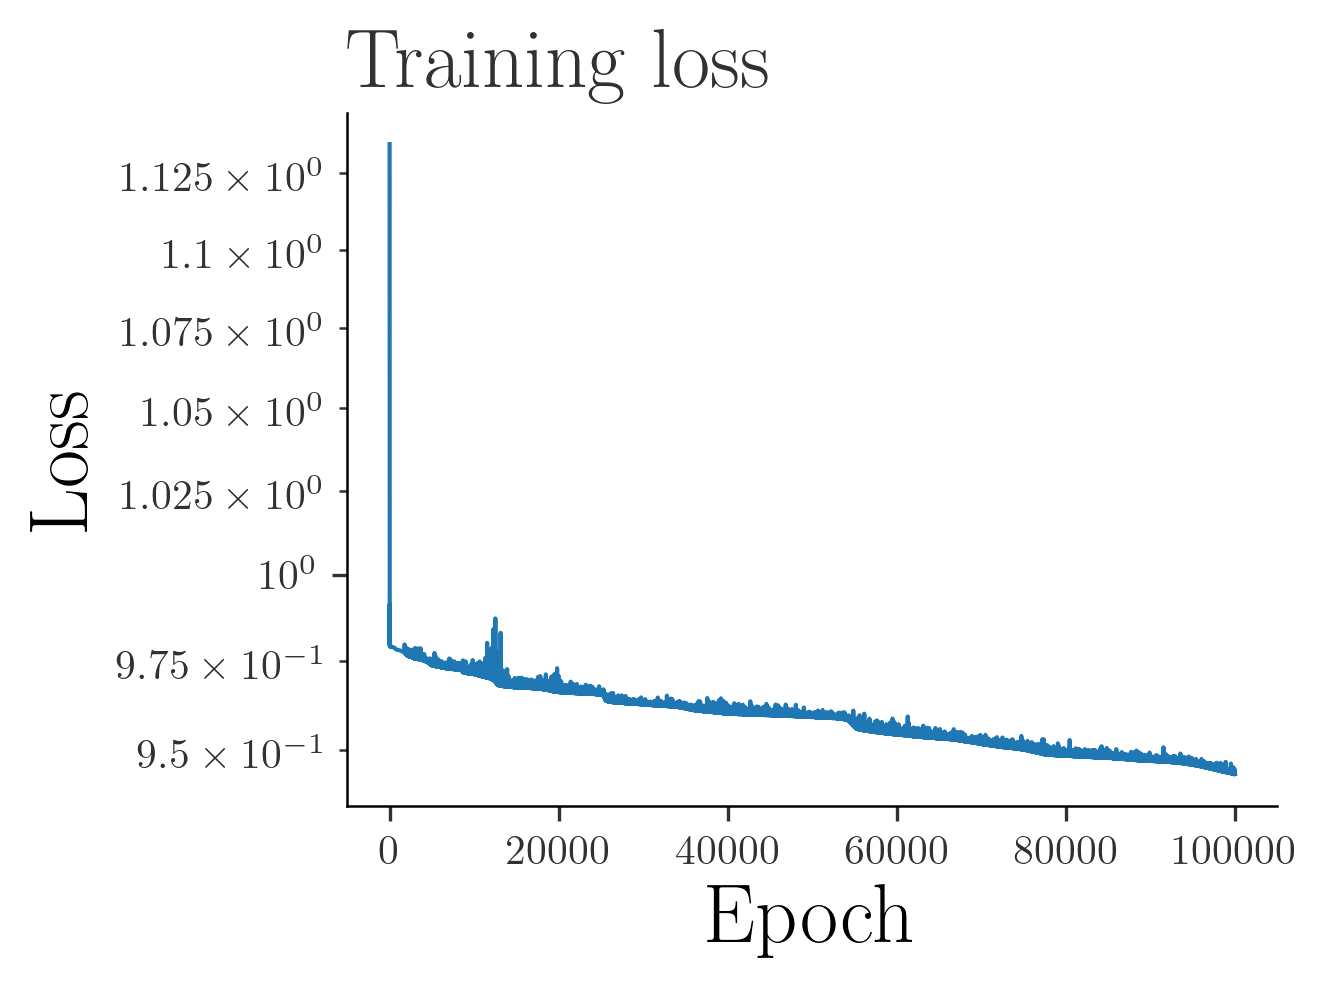

In [117]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

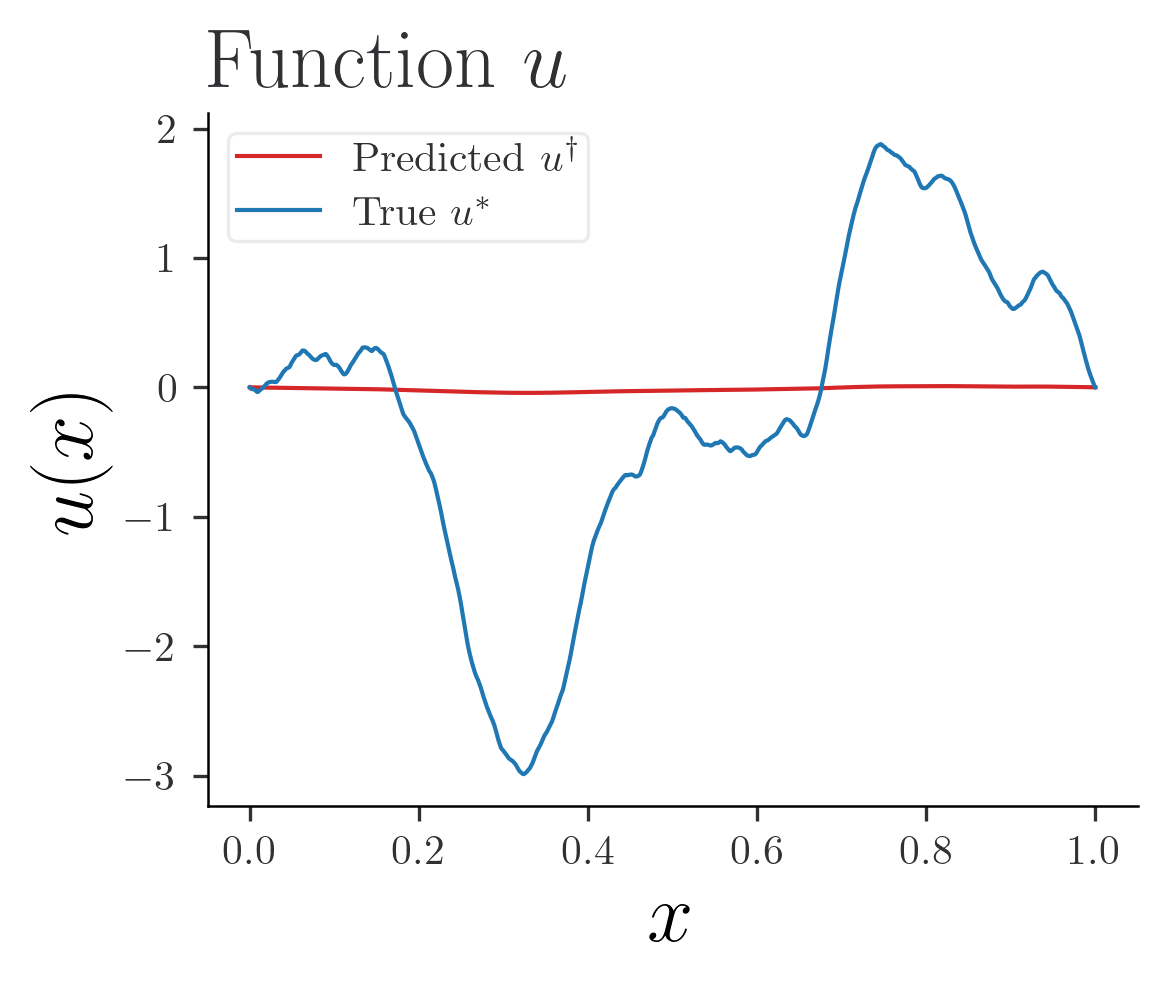

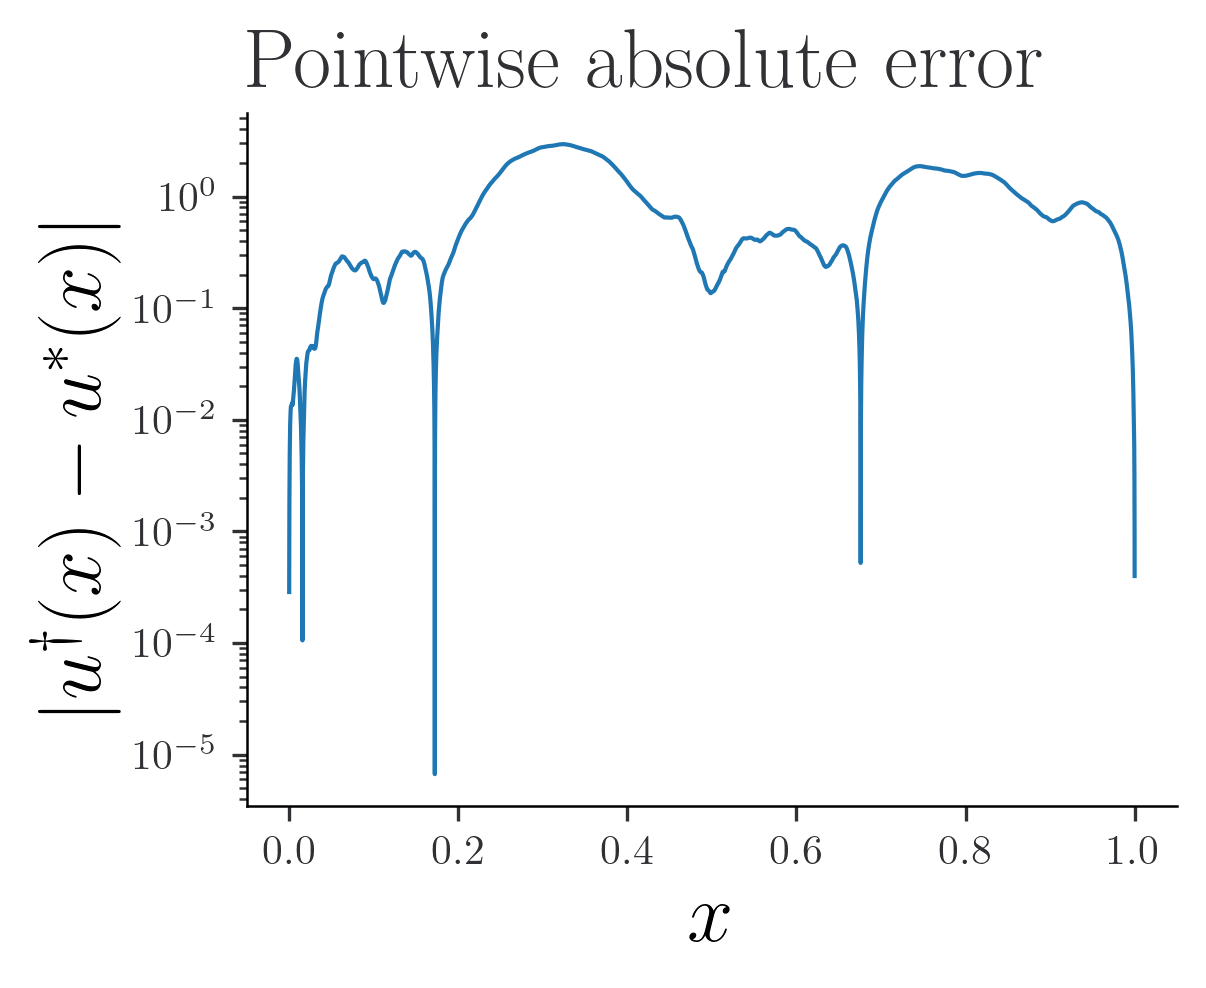

In [118]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


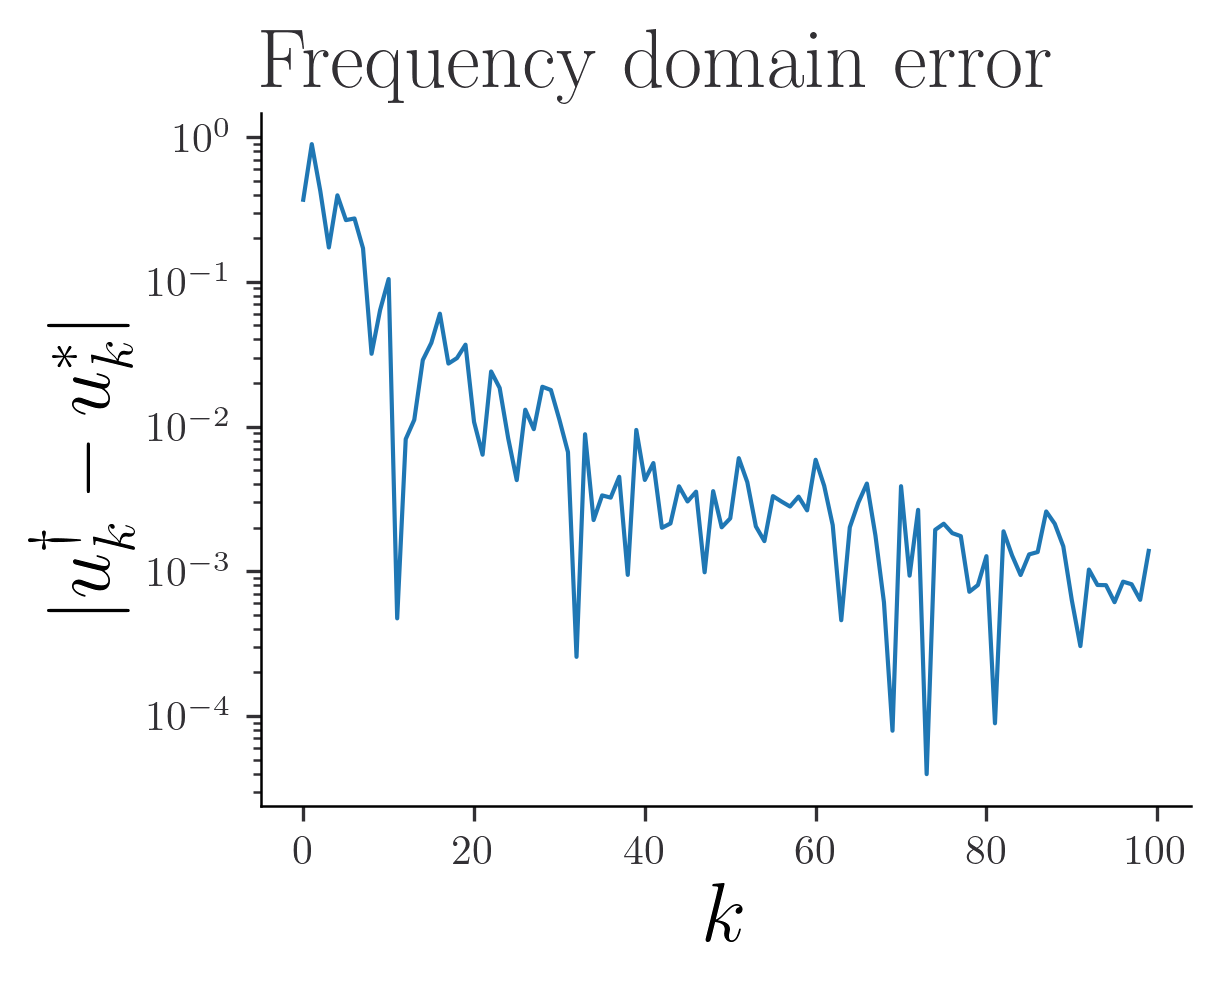

In [119]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

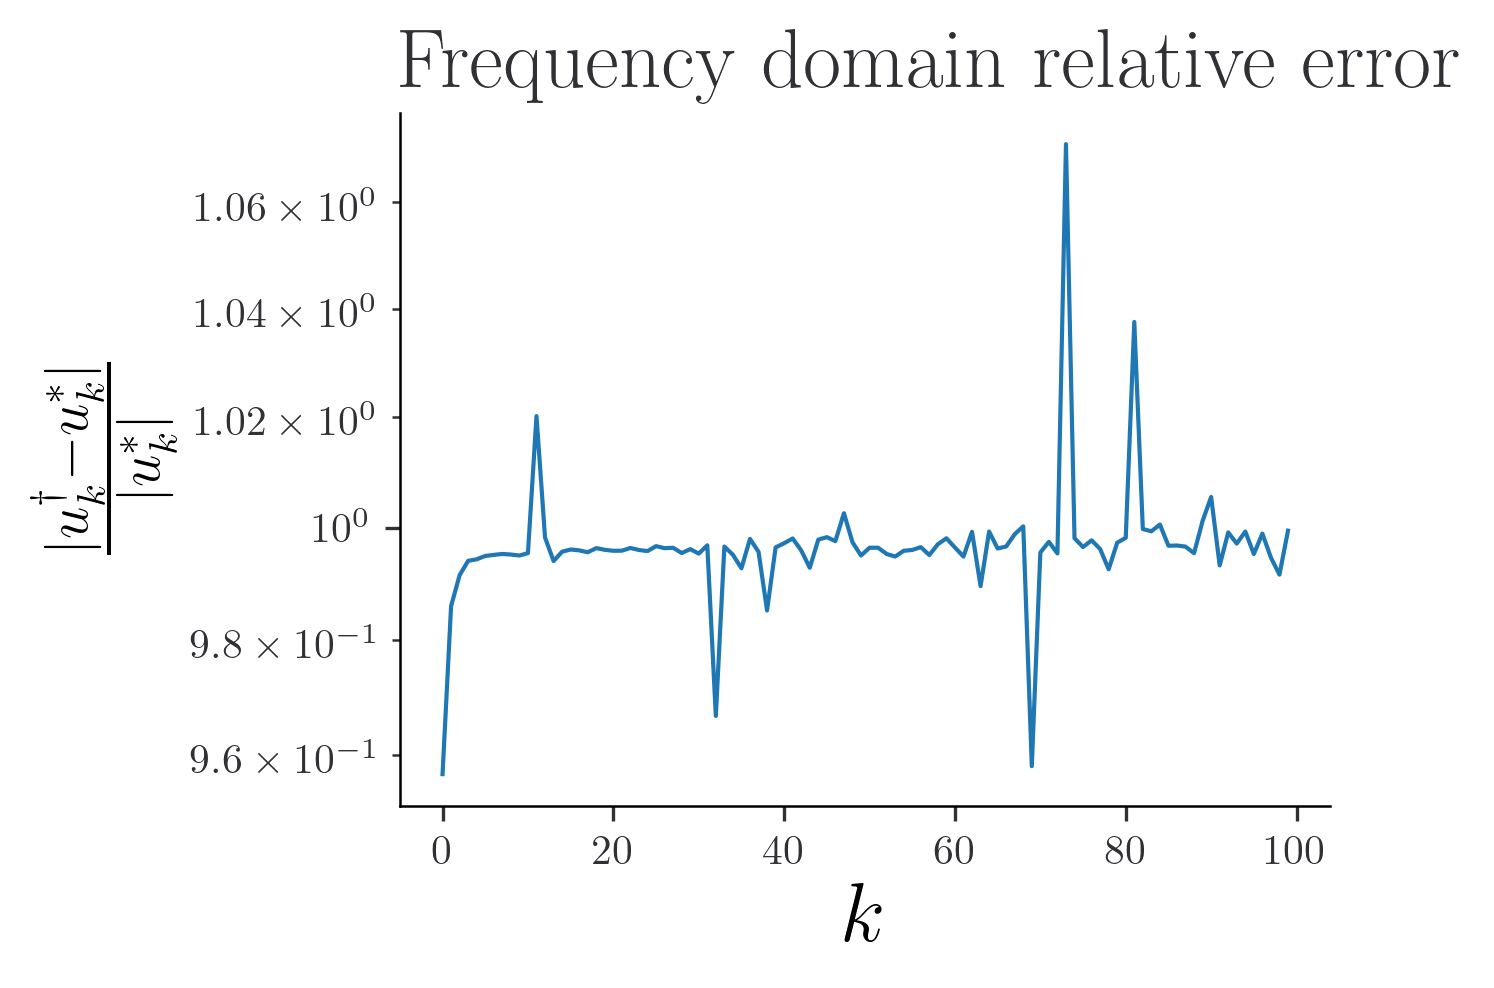

In [120]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 pointwise

In [39]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [41]:
layer_sizes = [1, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred =-nu*laplacian_grid + u_grid
    residual_interior = (pred - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1153 parameters in the neural network.


In [42]:
ratio = int(n_coef/n_meas)
f_observed =  f_values[::ratio]
f_observed.shape

(4096,)

In [43]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
16566.8714798466 [(Array([[-0.27476521,  0.12799837,  0.12785488, -0.06551848, -0.10561561,
        -0.01311075, -0.12427169,  0.94845188,  0.19712649, -0.03784708,
        -0.54064215,  0.20961168, -0.02940882, -1.09693859, -0.47426656,
        -0.04496949, -0.11480972,  0.025159  , -0.44416181, -0.31256193,
         0.24414224,  0.15368832, -0.82440988,  0.01086308,  0.69413606,
        -0.02230104,  0.00265732,  0.69572515, -0.00846487,  0.38411093,
         0.34076658, -0.02276806]], dtype=float64), Array([-0.29205111,  0.21821763,  0.50040849, -0.3511917 , -0.06143472,
        0.12353071, -0.35980917,  1.4887482 ,  0.64031136, -0.23334411,
       -0.81556404,  0.41129514, -0.29528973, -1.67088973, -0.63859313,
       -0.06599515, -0.49036223,  0.96309344, -0.69936754, -0.7328663 ,
        0.94472531,  0.24979915, -1.32681971,  0.04881623,  0.60815057,
       -0.3211835 ,  0.23884479,  0.87479562, -0.29559611,  0.64296484,
        0.43708358, -0.63804522], dty

In [44]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [45]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [46]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 16566.8714798
Step 0, Training Loss: 16566.8714798, Learning Rate: 0.001000
Epoch 10000, Loss: 16058.2839763
Step 10000, Training Loss: 16058.2839763, Learning Rate: 0.000900
Epoch 20000, Loss: 16027.7457092
Step 20000, Training Loss: 16027.7457092, Learning Rate: 0.000810
Epoch 30000, Loss: 16020.7964528
Step 30000, Training Loss: 16020.7964528, Learning Rate: 0.000729
Epoch 40000, Loss: 16020.2283200
Step 40000, Training Loss: 16020.2283200, Learning Rate: 0.000656
Epoch 50000, Loss: 16020.0348758
Step 50000, Training Loss: 16020.0348758, Learning Rate: 0.000590
Epoch 60000, Loss: 16019.9579629
Step 60000, Training Loss: 16019.9579629, Learning Rate: 0.000531
Epoch 70000, Loss: 16019.7034814
Step 70000, Training Loss: 16019.7034814, Learning Rate: 0.000478
Epoch 80000, Loss: 16019.6291700
Step 80000, Training Loss: 16019.6291700, Learning Rate: 0.000430
Epoch 90000, Loss: 16019.3803164
Step 90000, Training Loss: 16019.3803164, Learning Rate: 0.000387


In [47]:
pred = neural_network(params, domain_finest)

In [48]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

2.0018883473965743 1.6086110778319946


In [49]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(2.00188402, dtype=float64), Array(1.6086076, dtype=float64))

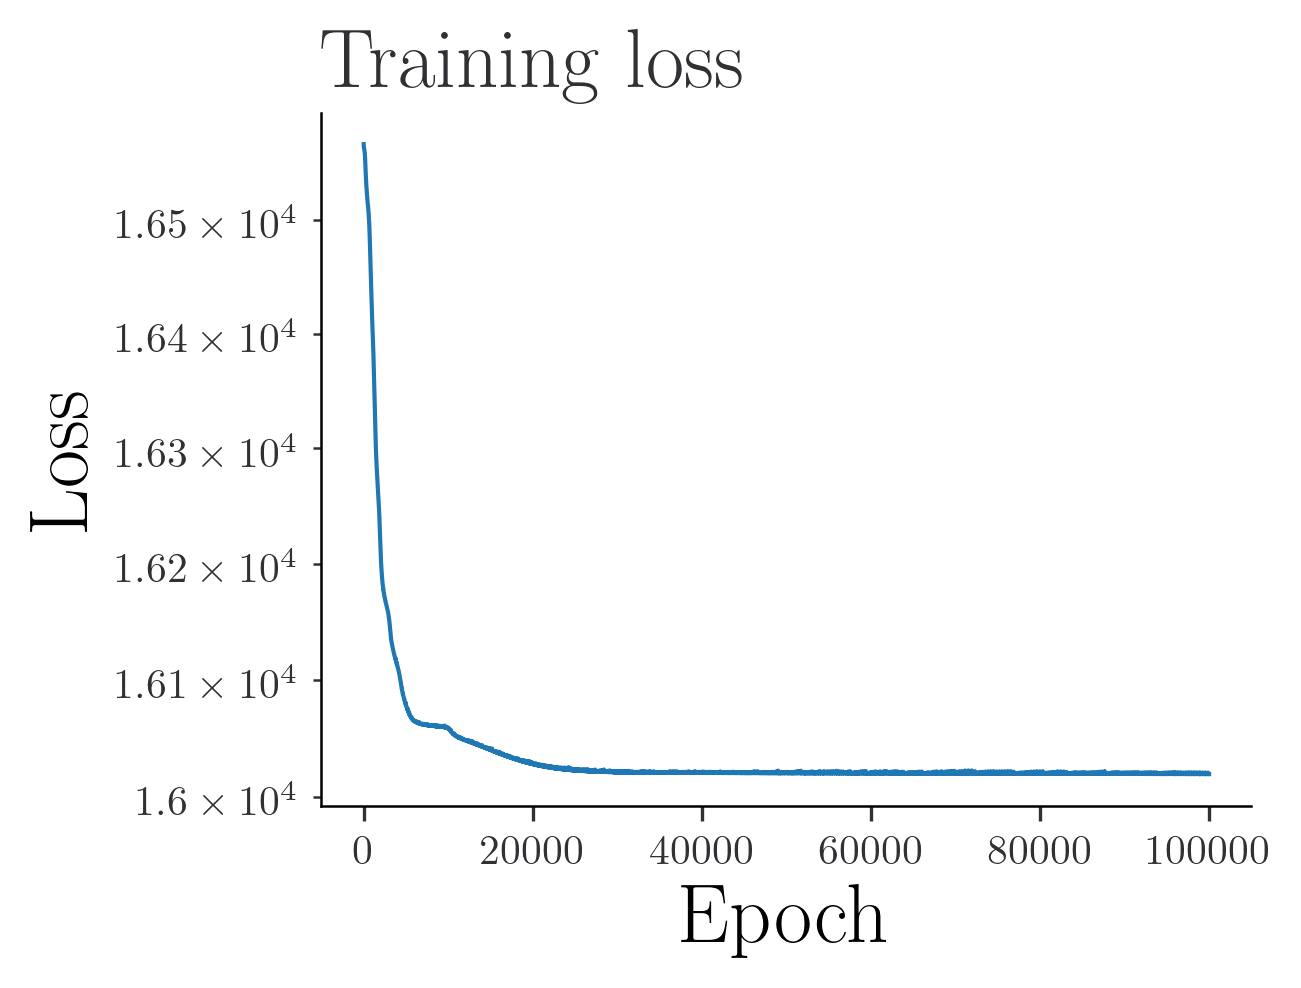

In [61]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

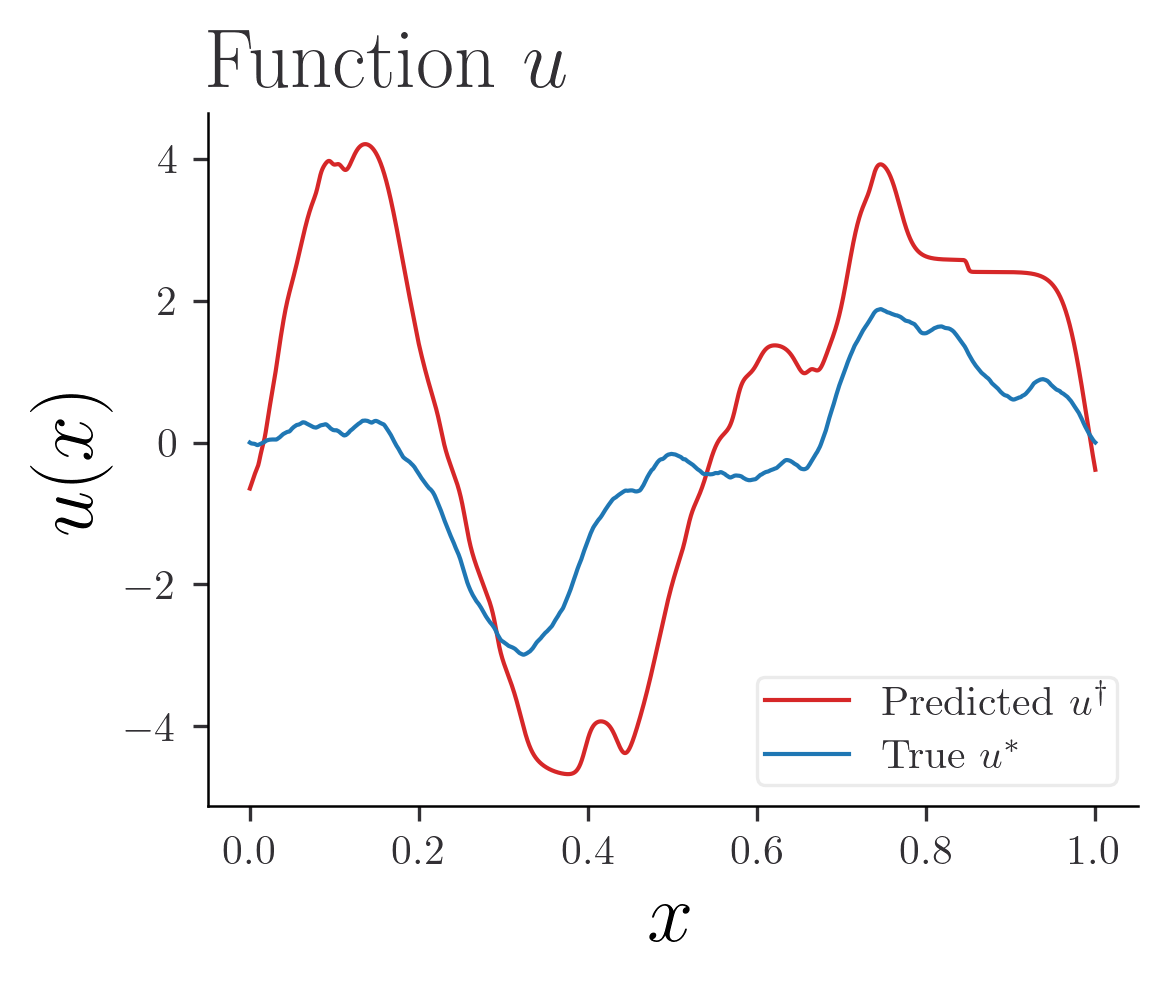

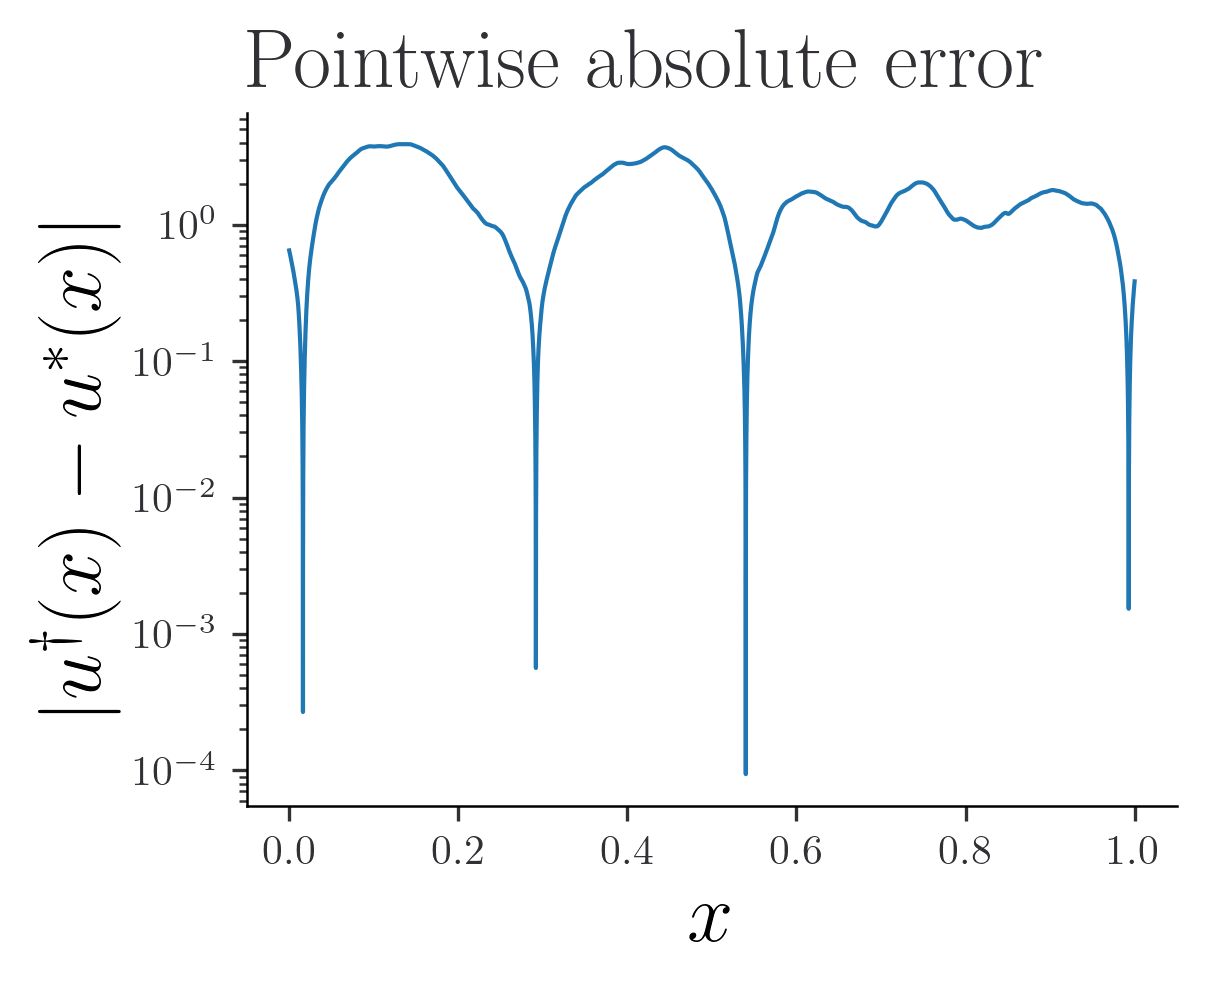

In [62]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


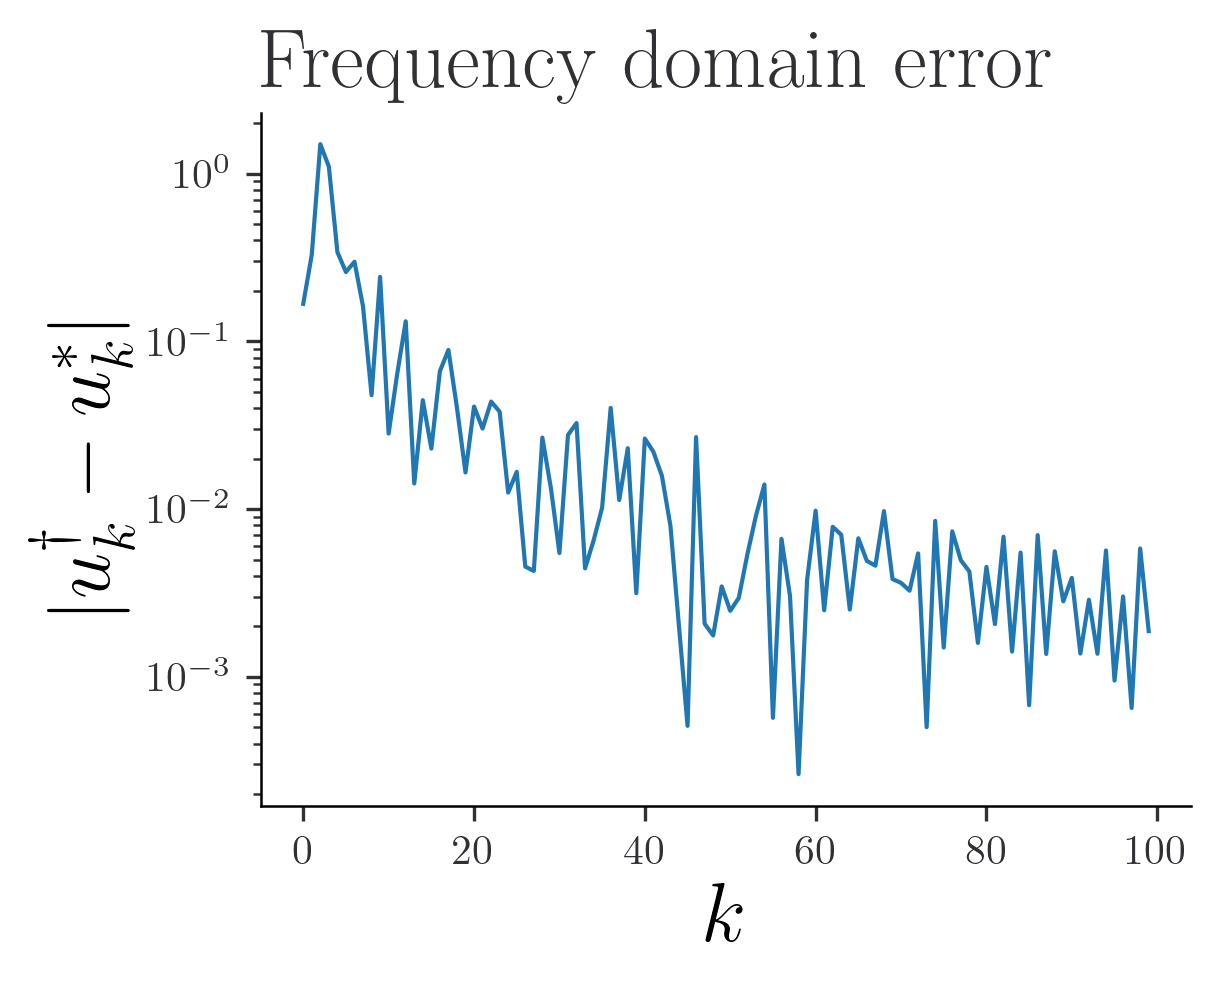

In [63]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

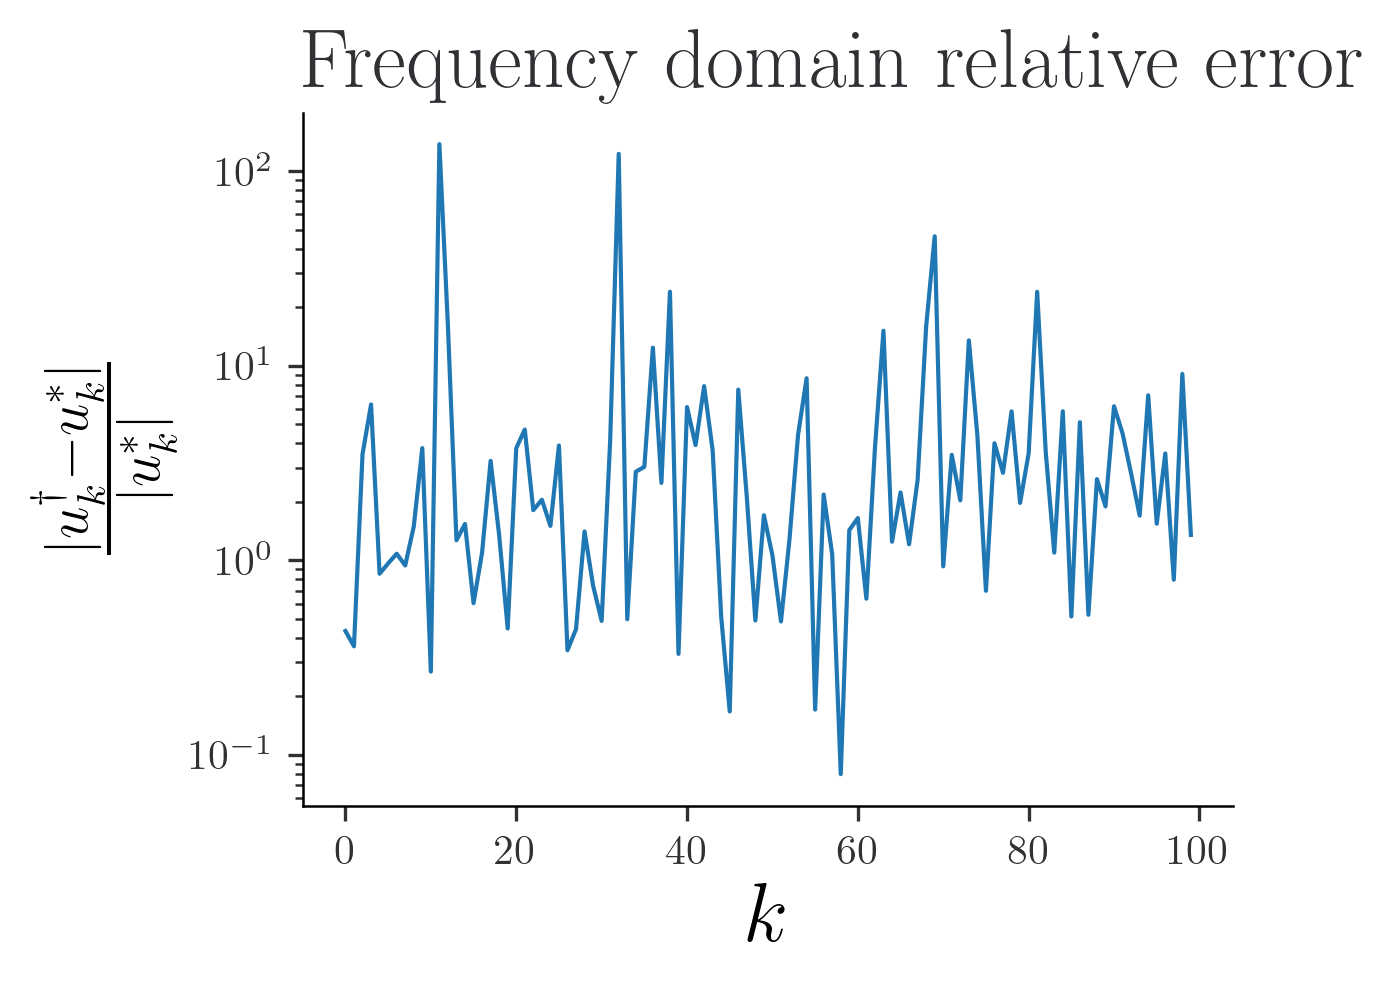

In [64]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF (unweighted norm)

In [27]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [57]:
# Draw random samples for the RF part
n_samples = 32
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 1.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  32


In [58]:
layer_sizes = [n_samples*2, 32, 32,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 3169 parameters in the neural network.


In [59]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [60]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
1.0436069380473851 [(Array([[ 1.13139632e-02, -1.68791852e-02, -1.87115791e-02, ...,
        -2.38208838e-02, -2.91220092e-03,  2.59531509e-02],
       [ 1.17787666e-02, -1.75895650e-02, -1.93621281e-02, ...,
        -2.46397063e-02, -3.05823148e-03,  2.68116486e-02],
       [ 1.05343096e-02, -1.56877923e-02, -1.76200257e-02, ...,
        -2.24470151e-02, -2.66732572e-03,  2.45124076e-02],
       ...,
       [-5.85897048e-04,  8.95181168e-04,  8.20663139e-04, ...,
         1.03293177e-03,  1.83867246e-04, -1.08343911e-03],
       [ 5.80986311e-04, -8.87680261e-04, -8.13780033e-04, ...,
        -1.02426842e-03, -1.82327605e-04,  1.07434862e-03],
       [-6.99385623e-05,  1.06865775e-04,  9.79451841e-05, ...,
         1.23279655e-04,  2.19536471e-05, -1.29294372e-04]],      dtype=float64), Array([ 0.0667847 , -0.09973688, -0.10974418,  0.08039896, -0.04944843,
       -0.06927849,  0.13118807, -0.18018201, -0.14456408,  0.00344194,
        0.11142332, -0.01707402,  0

In [61]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [62]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [63]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 1.0436069
Step 0, Training Loss: 1.0436069, Learning Rate: 0.001000
Epoch 10000, Loss: 0.9778212
Step 10000, Training Loss: 0.9778212, Learning Rate: 0.000900
Epoch 20000, Loss: 0.9723547
Step 20000, Training Loss: 0.9723547, Learning Rate: 0.000810
Epoch 30000, Loss: 0.9663163
Step 30000, Training Loss: 0.9663163, Learning Rate: 0.000729
Epoch 40000, Loss: 0.9642406
Step 40000, Training Loss: 0.9642406, Learning Rate: 0.000656
Epoch 50000, Loss: 0.9628532
Step 50000, Training Loss: 0.9628532, Learning Rate: 0.000590
Epoch 60000, Loss: 0.9608838
Step 60000, Training Loss: 0.9608838, Learning Rate: 0.000531
Epoch 70000, Loss: 0.9568188
Step 70000, Training Loss: 0.9568188, Learning Rate: 0.000478
Epoch 80000, Loss: 0.9546292
Step 80000, Training Loss: 0.9546292, Learning Rate: 0.000430
Epoch 90000, Loss: 0.9529724
Step 90000, Training Loss: 0.9529724, Learning Rate: 0.000387


In [64]:
pred = neural_network(params, domain_finest)

In [65]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

0.107326226188655 0.08624165109582485


In [66]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(0.10732623, dtype=float64), Array(0.08624165, dtype=float64))

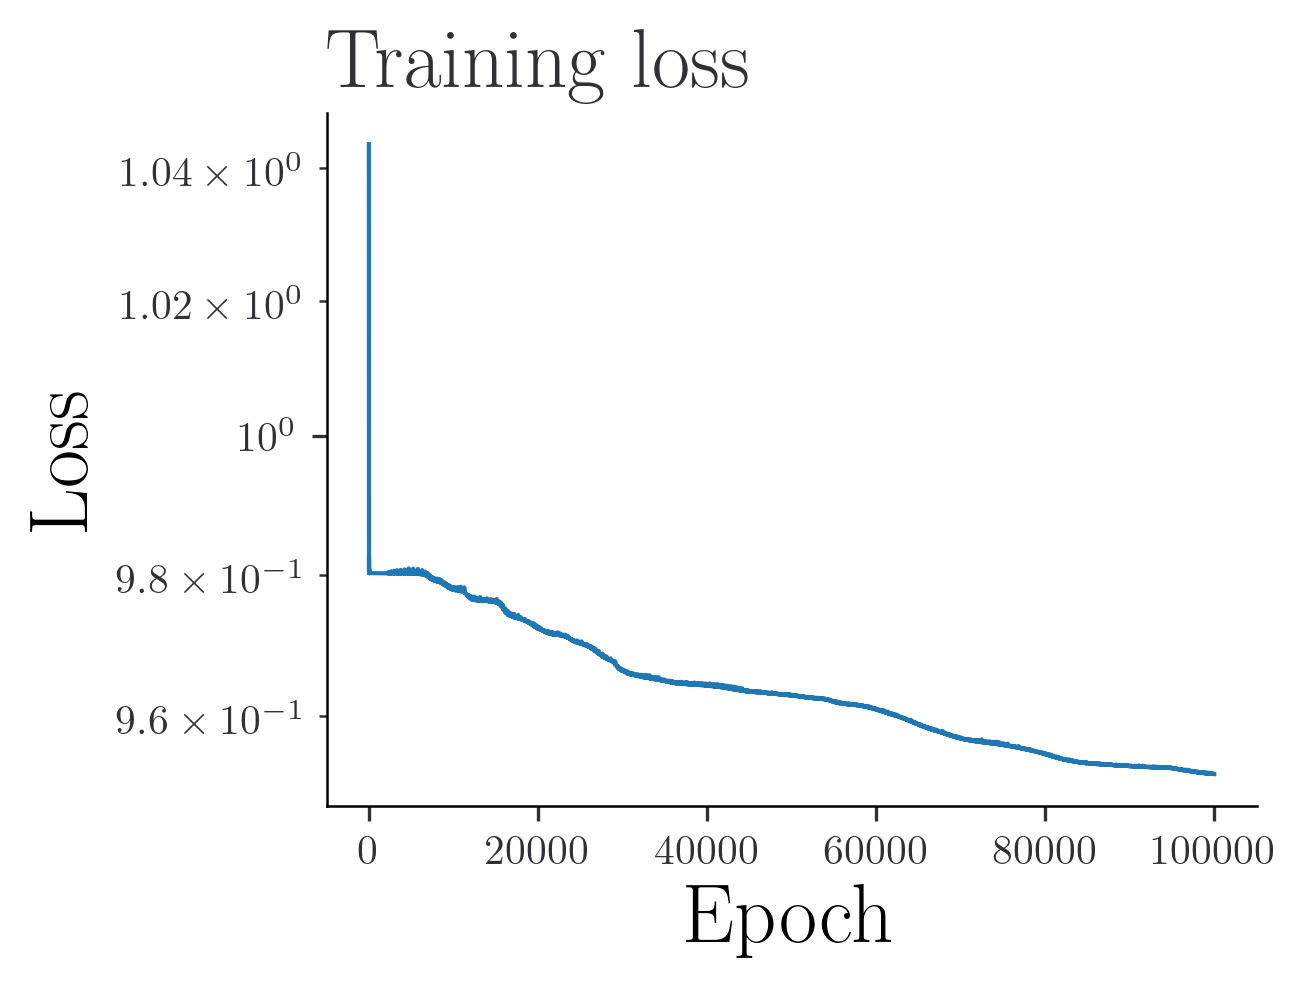

In [67]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

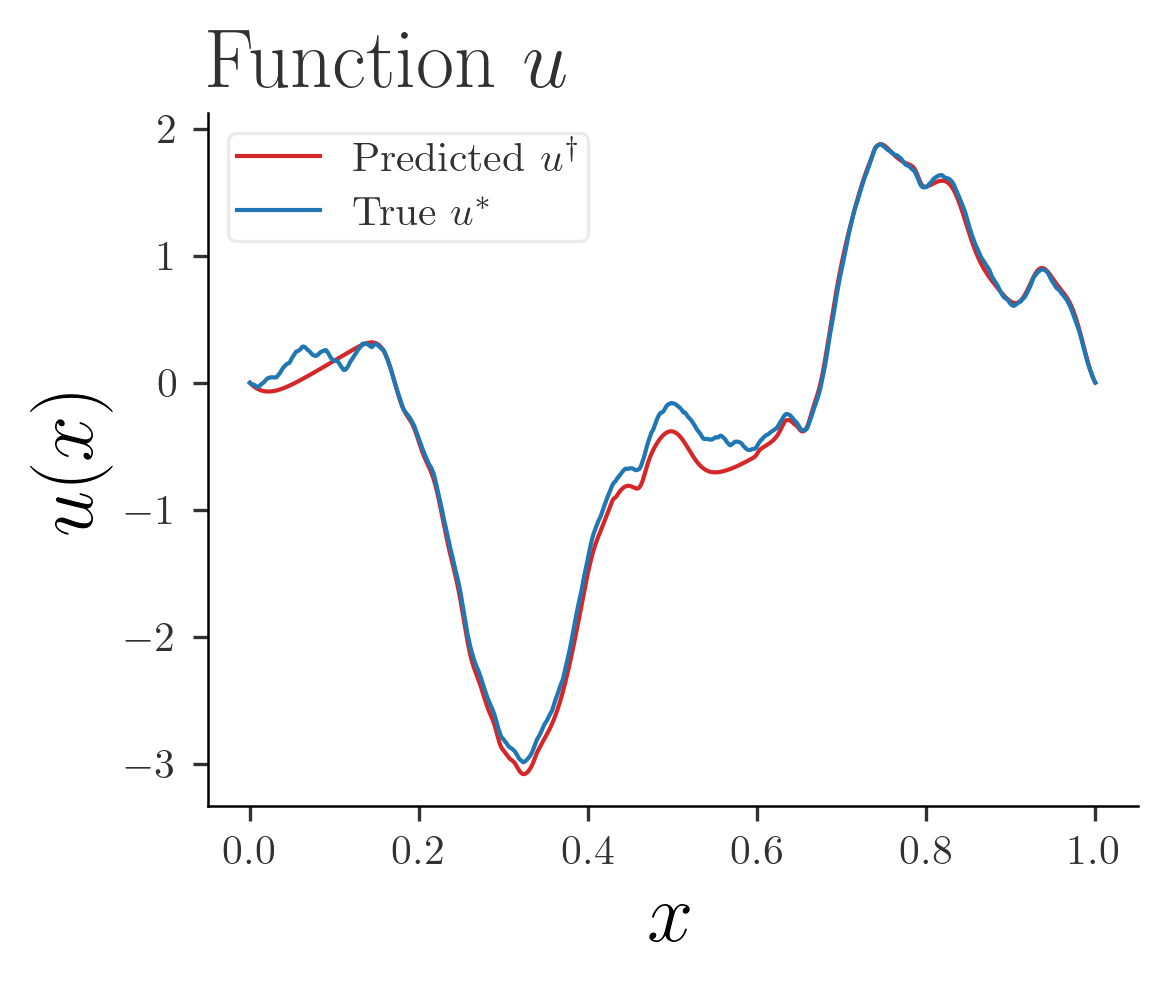

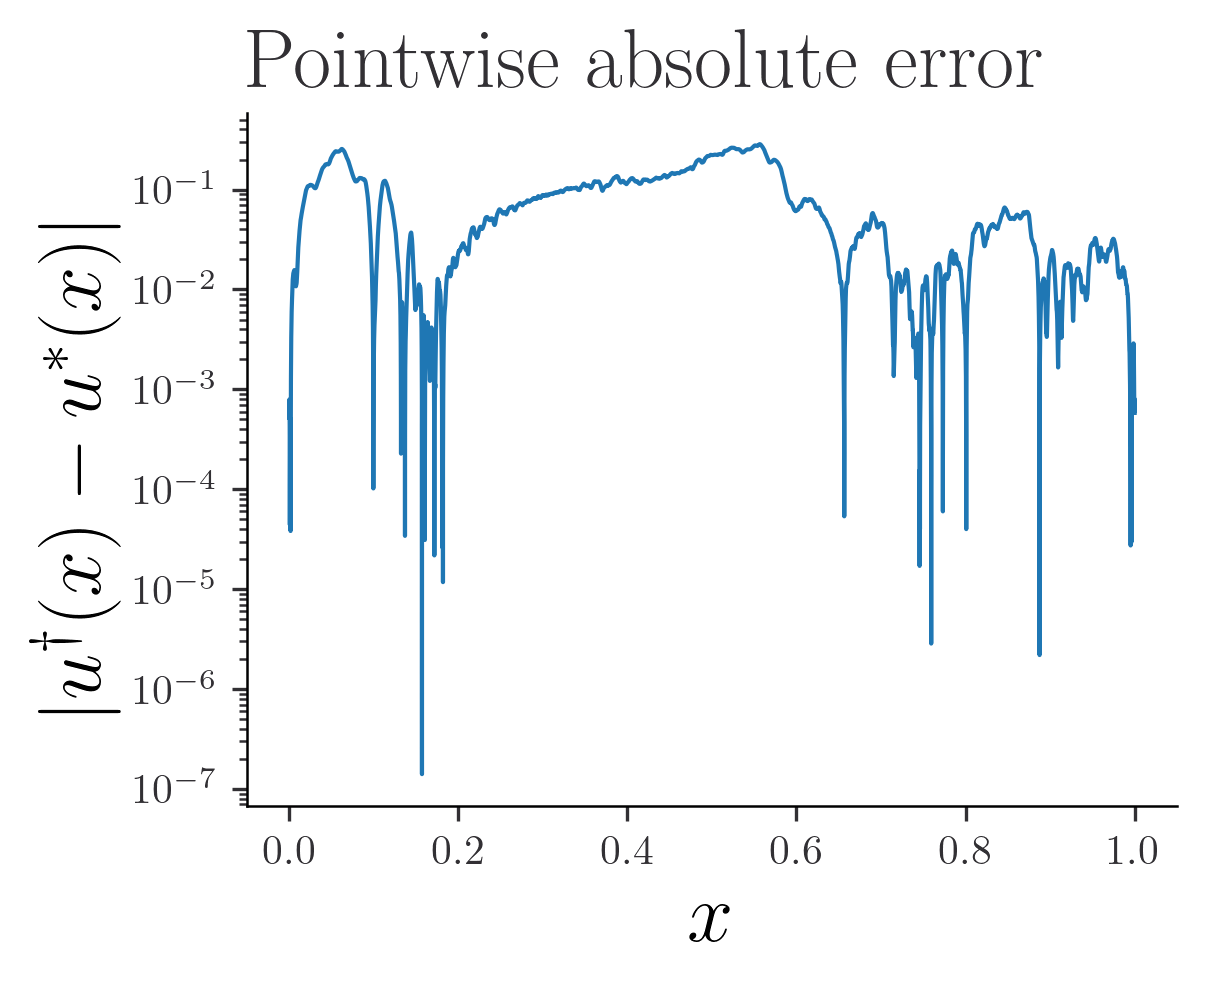

In [68]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


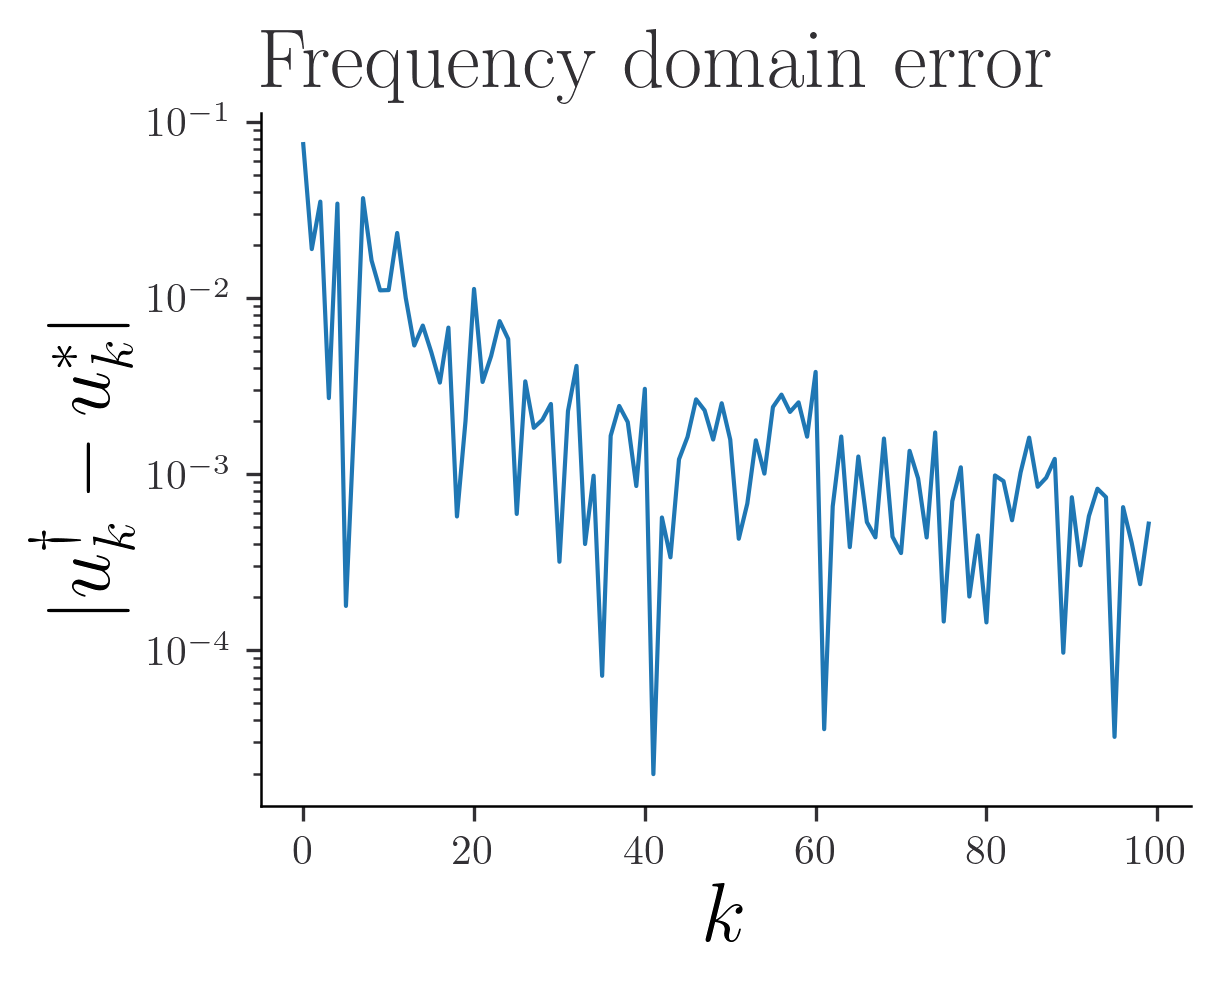

In [69]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

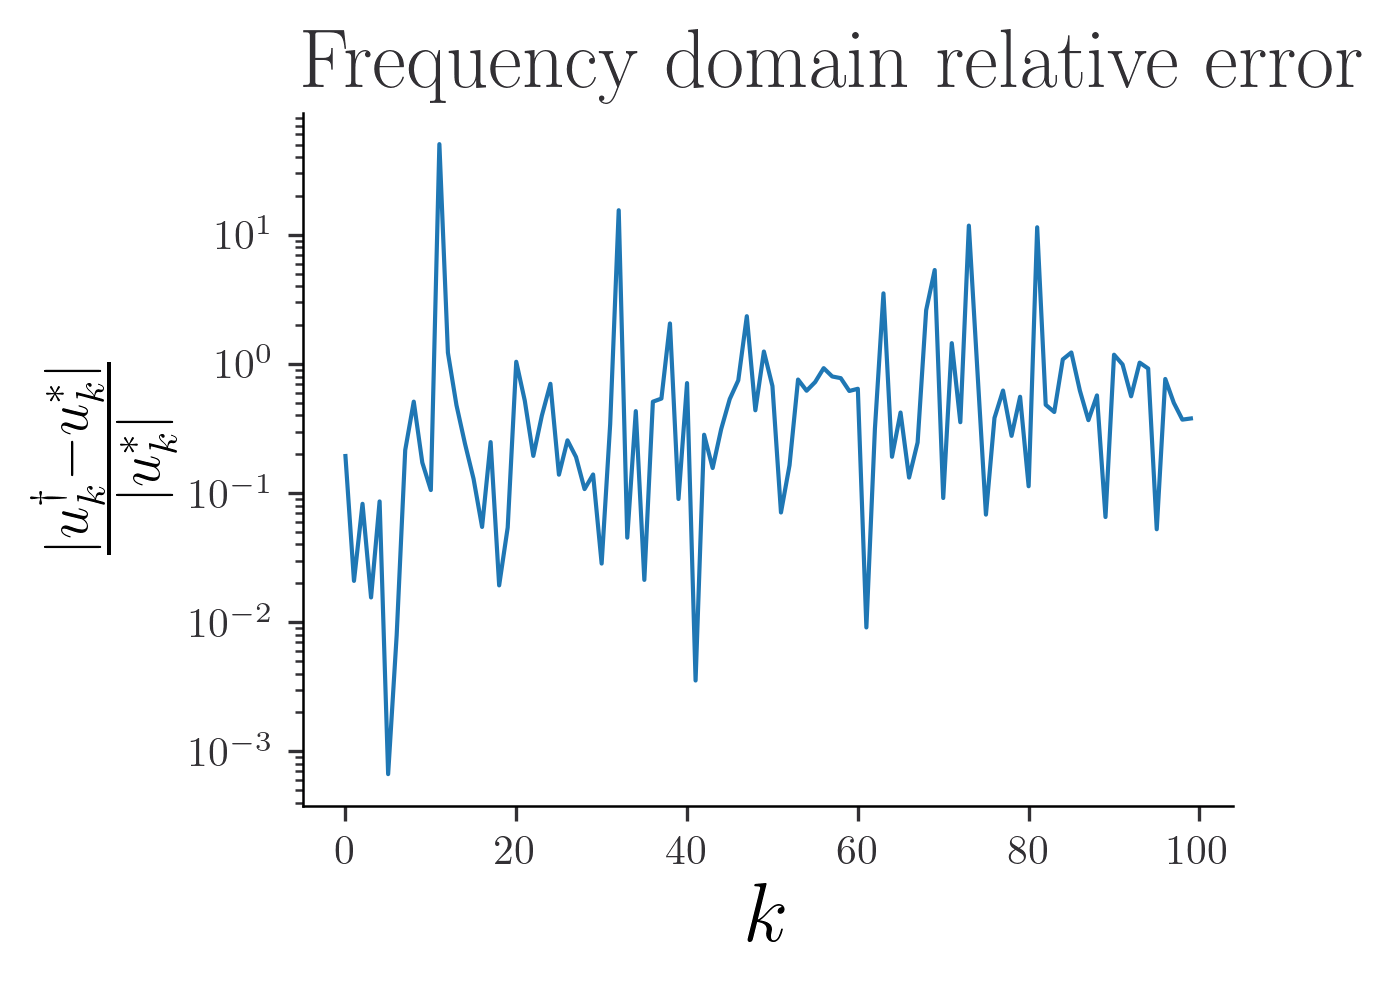

In [70]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()

# PINN 4096 measurements + RFF ($H^{-1/2}$ norm)

In [123]:
n_meas = 2**12
print(n_meas)
domain_measurements = jnp.linspace(0,1, n_meas+1, endpoint=False)[1:] # Do not include 0 or 1!
domain_measurements.shape

4096


(4096,)

In [125]:
decay = jnp.arange(1, n_meas+1)**(-0.5)
decay

Array([1.        , 0.70710678, 0.57735027, ..., 0.01562882, 0.01562691,
       0.015625  ], dtype=float64, weak_type=True)

In [131]:
# Draw random samples for the RF part
n_samples = 24
print('Number of samples: ', n_samples)
d_in = 1

key = random.PRNGKey(0)
key, subkey = random.split(key)
sigma_rff = 5.0
random_features = random.normal(subkey, shape = (n_samples, d_in))*sigma_rff

def feature_map(x, random_features):
    n_samples = random_features.shape[0]
    outputs = jnp.dot(random_features, x)
    return jnp.squeeze((1/jnp.sqrt(n_samples))*jnp.vstack([jnp.cos(outputs), jnp.sin(outputs)]))


def predict(params, x):
    activations = x
    # First pass through the feature map
    activations = feature_map(activations, random_features)
    for weights, biases in params[:-1]:
        activations = jnp.tanh(jnp.dot(activations, weights) + biases)
    final_weights, final_biases = params[-1]
    return jnp.squeeze(jnp.dot(activations, final_weights) + final_biases)

Number of samples:  24


In [132]:
layer_sizes = [n_samples*2, 16, 16,  1]
key = random.PRNGKey(0)
params = init_params(layer_sizes, key)
print("There are {} parameters in the neural network.".format(count_parameters(params)))


neural_network = jit(vmap(predict, in_axes=(None, 0)))
neural_network_hess = jit(vmap(hessian(predict, argnums=-1), in_axes=(None, 0)))

# Define the loss function
def loss_fn(params, grid, boundary, f, boundary_conditions, nu, w = 1.0):
    u_grid = neural_network(params, grid)
    laplacian_grid = neural_network_hess(params, grid)
    # Compute the sine transform
    pred_sine = compute_sine_coefficients(-nu*laplacian_grid + u_grid)
    residual_interior = (pred_sine - f)*decay

    pred_boundary = neural_network(params, boundary)
    residual_boundary = pred_boundary - boundary_conditions
    return w*jnp.mean(residual_interior**2) + jnp.mean(residual_boundary**2)

There are 1073 parameters in the neural network.


In [133]:
f_observed =  coef_f[:n_meas]
f_observed.shape

(4096,)

In [134]:
pred = predict(params, domain_measurements[0])
pred_laplacian = hessian(predict, argnums=-1)(params, domain_measurements[0])
print(pred.shape, pred_laplacian.shape)

pred_grid = neural_network(params, domain_measurements)
pred_laplacian_grid = neural_network_hess(params, domain_measurements)
print(pred_grid.shape, pred_laplacian_grid.shape)

loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu)
print(loss, grads)

() ()
(4096,) (4096,)
0.0272138864939573 [(Array([[-2.96229007e-03,  2.98176717e-03,  1.79705983e-03,
         4.72990308e-03,  3.56558922e-03, -1.89621922e-02,
        -8.61193895e-04, -9.34947018e-03,  9.85671146e-03,
         5.22732404e-03,  4.44621747e-03,  1.52745381e-03,
         4.87823541e-04, -3.95546400e-03, -1.80756934e-03,
        -4.93648594e-03],
       [-1.10262045e-02,  1.31819864e-03,  4.98381428e-03,
         8.42971253e-03,  8.83724058e-03, -3.72615606e-02,
        -4.90392488e-03, -2.10466316e-02,  2.62880464e-02,
         1.35765931e-02,  7.71198701e-03,  6.74463725e-03,
         1.86296886e-03, -9.55468225e-03, -5.88791327e-03,
        -1.17477454e-02],
       [-5.46557019e-03,  2.35091738e-03,  2.69598247e-03,
         5.85394474e-03,  5.35733591e-03, -2.52230692e-02,
        -2.21536079e-03, -1.31801074e-02,  1.54733118e-02,
         8.18548118e-03,  5.44137101e-03,  3.34481741e-03,
         9.43685788e-04, -5.98476231e-03, -3.13226690e-03,
        -7.38535356e

In [135]:
# Define the learning rate scheduler
initial_learning_rate = 1e-3
num_epochs = 1e5
decay_steps = num_epochs/10
decay_rate = 0.9

learning_rate_schedule = optax.exponential_decay(
    init_value=initial_learning_rate,
    transition_steps=decay_steps,
    decay_rate=decay_rate,
    transition_begin=0,
    staircase=False
)
optimizer = optax.adam(learning_rate_schedule)
opt_state = optimizer.init(params)

In [136]:
@jit
def train_step(params, opt_state):
    loss, grads = value_and_grad(loss_fn)(params, domain_measurements, boundary, f_observed,boundary_conditions, nu, 1.0)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


In [137]:
loss_hist = []
for epoch in range(int(num_epochs)):
    params, opt_state, loss = train_step(params, opt_state)
    if epoch % 1e4 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.7f}')
    loss_hist.append(loss)

    if epoch % decay_steps == 0:
        current_learning_rate = learning_rate_schedule(epoch)
        print(f'Step {epoch}, Training Loss: {loss:.7f}, Learning Rate: {current_learning_rate:.6f}')

Epoch 0, Loss: 0.0272139
Step 0, Training Loss: 0.0272139, Learning Rate: 0.001000
Epoch 10000, Loss: 0.0011314
Step 10000, Training Loss: 0.0011314, Learning Rate: 0.000900
Epoch 20000, Loss: 0.0010915
Step 20000, Training Loss: 0.0010915, Learning Rate: 0.000810
Epoch 30000, Loss: 0.0010437
Step 30000, Training Loss: 0.0010437, Learning Rate: 0.000729
Epoch 40000, Loss: 0.0010322
Step 40000, Training Loss: 0.0010322, Learning Rate: 0.000656
Epoch 50000, Loss: 0.0010293
Step 50000, Training Loss: 0.0010293, Learning Rate: 0.000590
Epoch 60000, Loss: 0.0010240
Step 60000, Training Loss: 0.0010240, Learning Rate: 0.000531
Epoch 70000, Loss: 0.0010055
Step 70000, Training Loss: 0.0010055, Learning Rate: 0.000478
Epoch 80000, Loss: 0.0010049
Step 80000, Training Loss: 0.0010049, Learning Rate: 0.000430
Epoch 90000, Loss: 0.0010002
Step 90000, Training Loss: 0.0010002, Learning Rate: 0.000387


In [138]:
pred = neural_network(params, domain_finest)

In [139]:
pred_transform = compute_sine_coefficients(pred)
L2_error = jnp.linalg.norm(pred_transform - coef_u)
relative_L2_error = L2_error/jnp.linalg.norm(coef_u)
print(L2_error, relative_L2_error)

error_freq = jnp.abs(pred_transform - coef_u)
error_freq_rel = jnp.abs(pred_transform - coef_u)/jnp.abs(coef_u)

1.2272645086131955 0.9861645313799002


In [140]:
compute_1d_error(pred, u_values, domain_finest, domain_measurements)

(Array(1.22726451, dtype=float64), Array(0.98616453, dtype=float64))

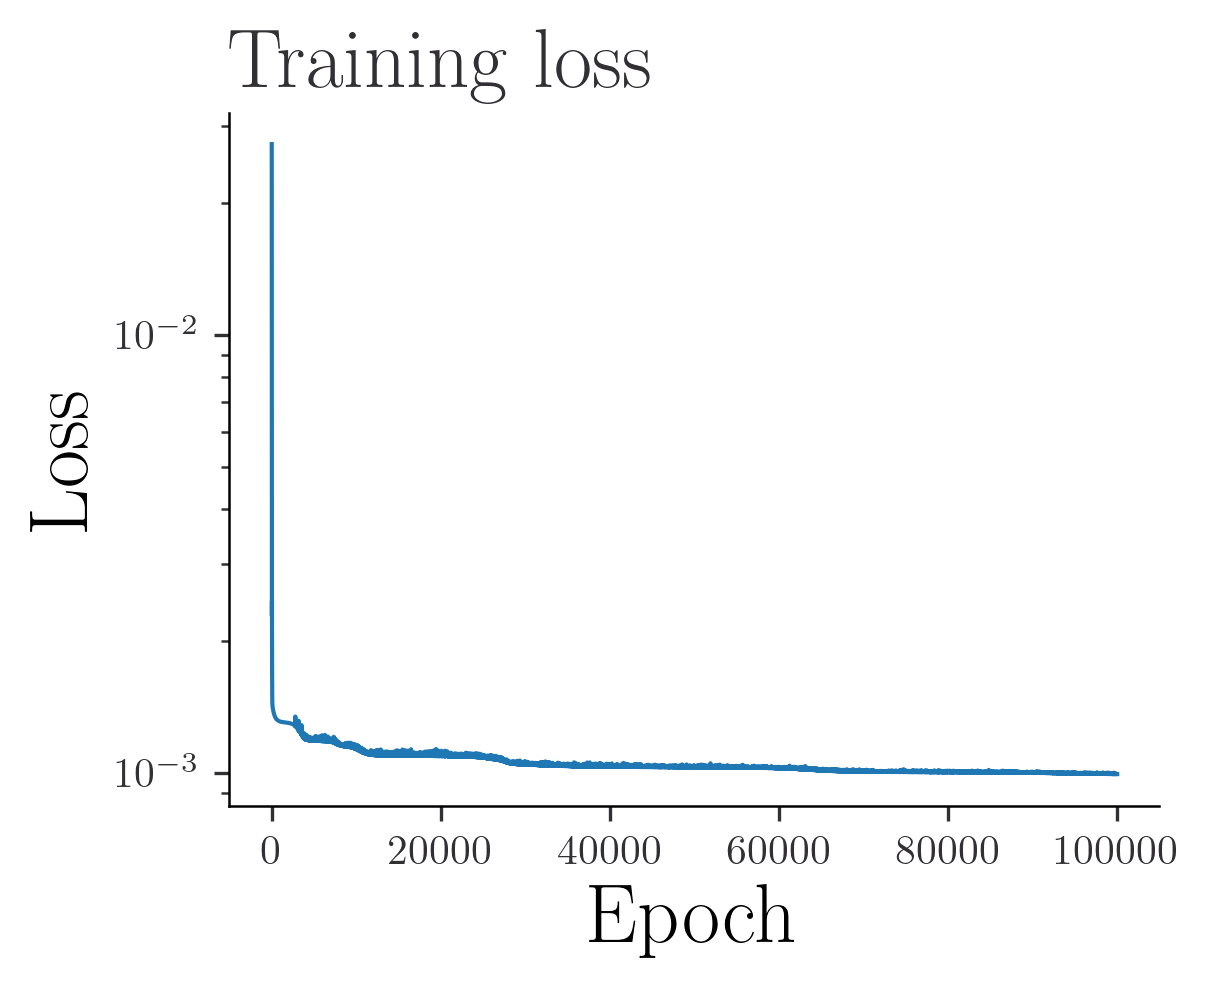

In [141]:
fig = plt.figure(figsize=(width, height))
plt.plot(loss_hist)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

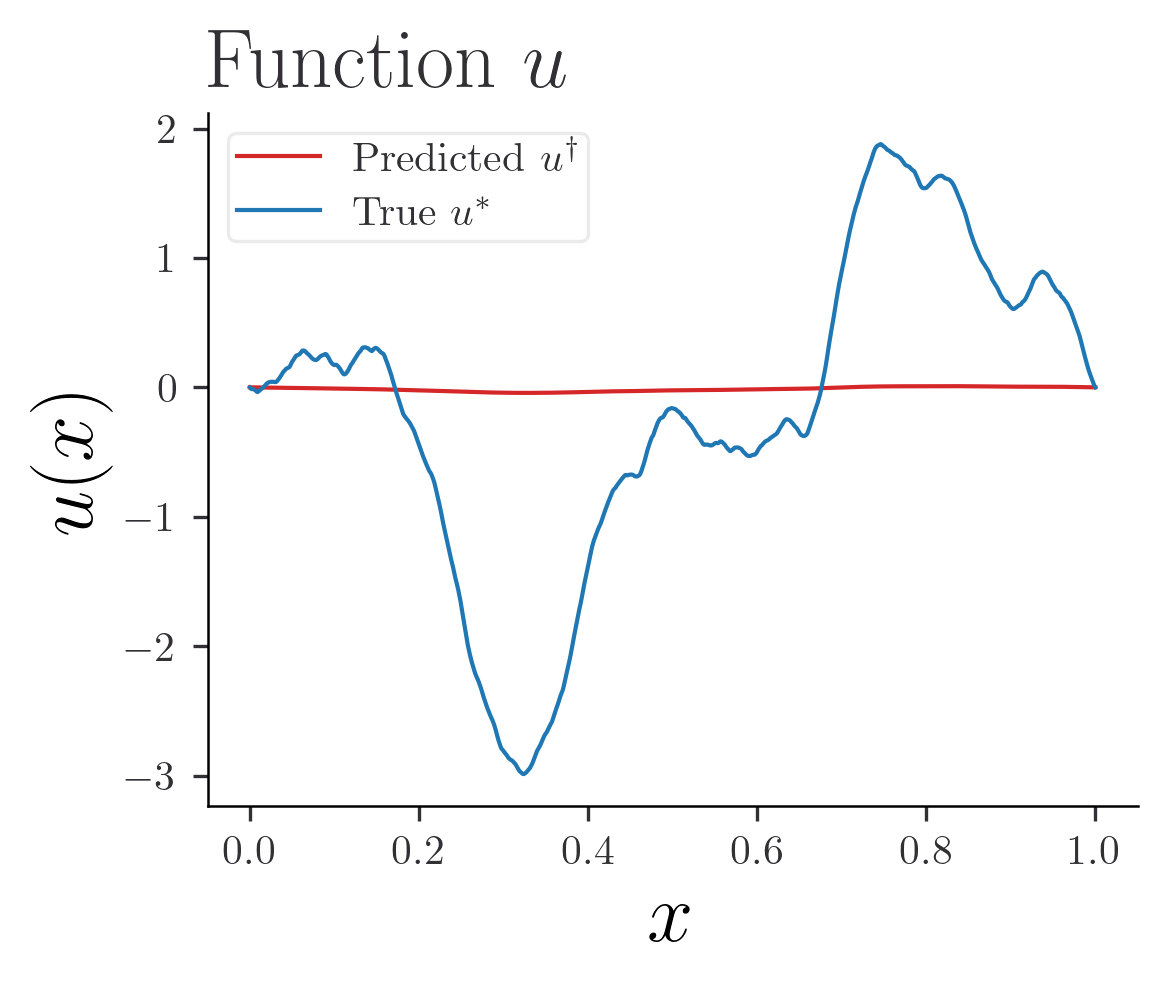

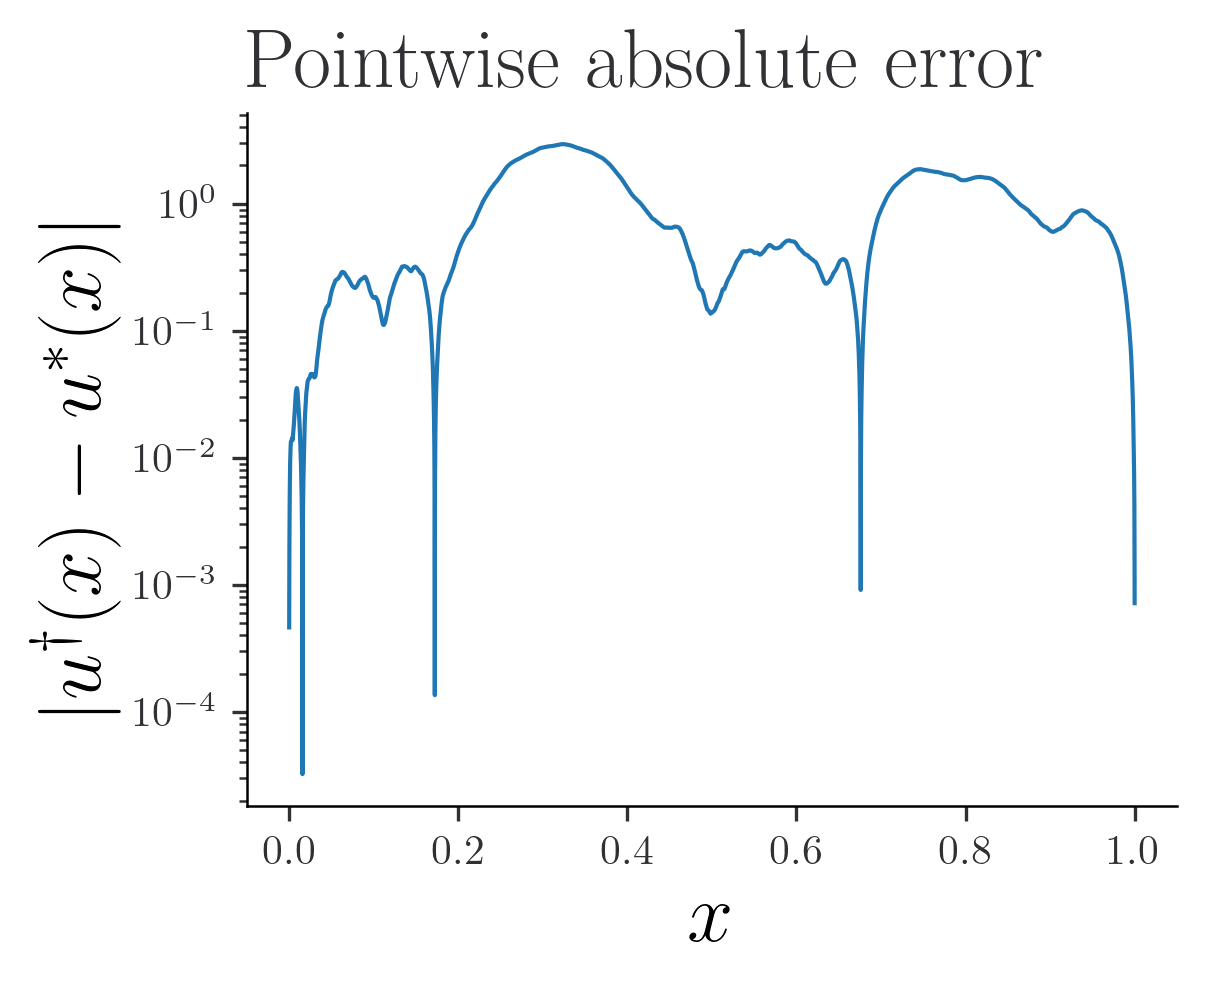

In [142]:
# Create plots for the prediction and the true function
fig = plt.figure(figsize=(width, height))
plt.plot(domain_finest, pred, label = r"Predicted $u^\dagger$", color = 'tab:red')
plt.plot(domain_finest, u_values, label = r"True $u^*$", color = 'tab:blue')
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.title(r"Function $u$")
plt.legend()
plt.show()

# Create plots for the pointwise error
figure = plt.figure(figsize=(width, height))
plt.plot(domain_finest, jnp.abs(pred - u_values))
plt.xlabel(r"$x$")
plt.ylabel(r"$|u^\dagger(x) - u^*(x)|$")
plt.title(r"Pointwise absolute error")
plt.yscale('log')
plt.show()


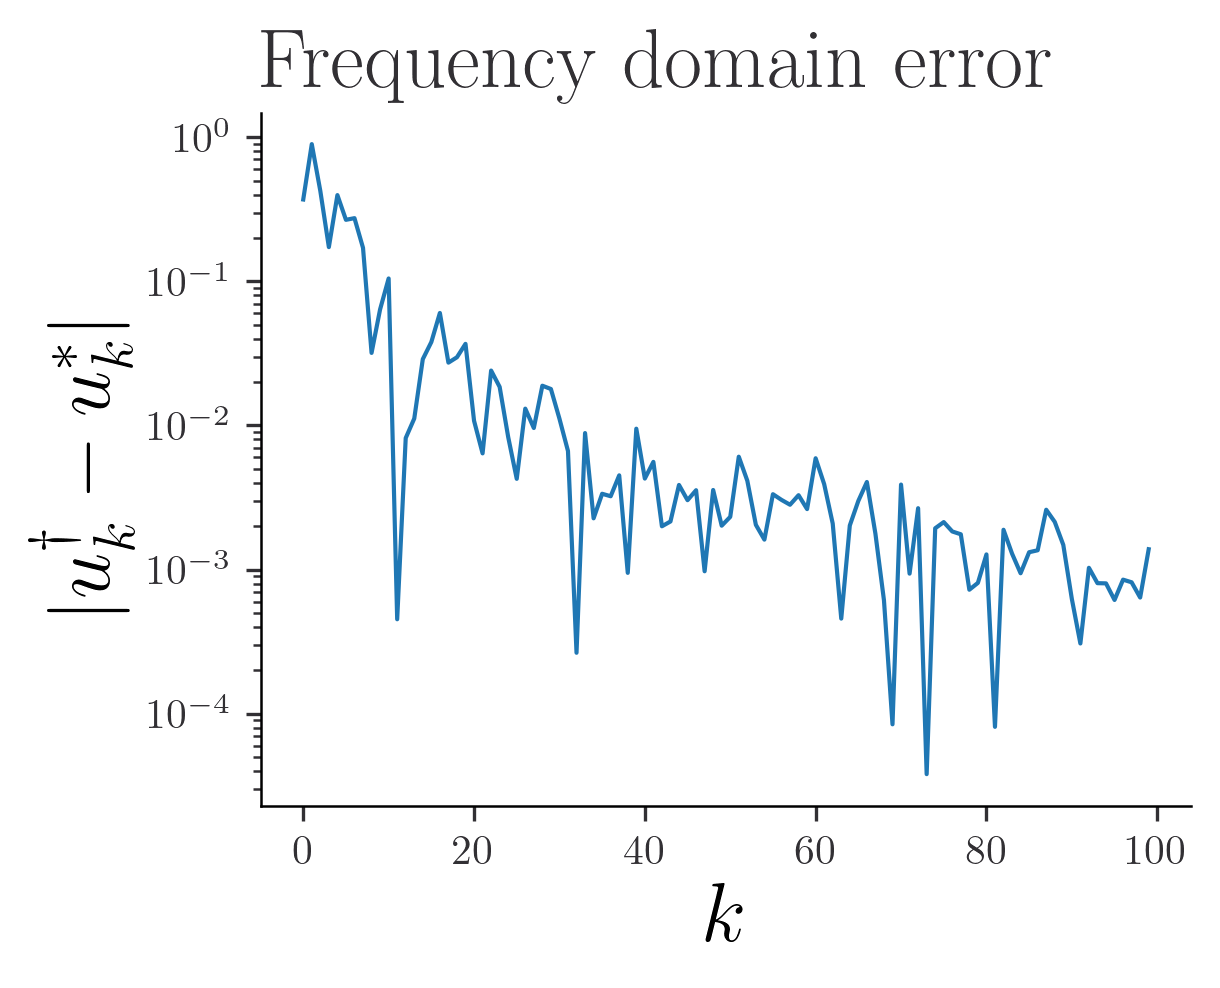

In [143]:
fig = plt.figure(figsize=(width, height))
plt.plot(error_freq[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$|{u}^\dagger_k - u^*_k|$")
plt.title(r"Frequency domain error")
plt.show()

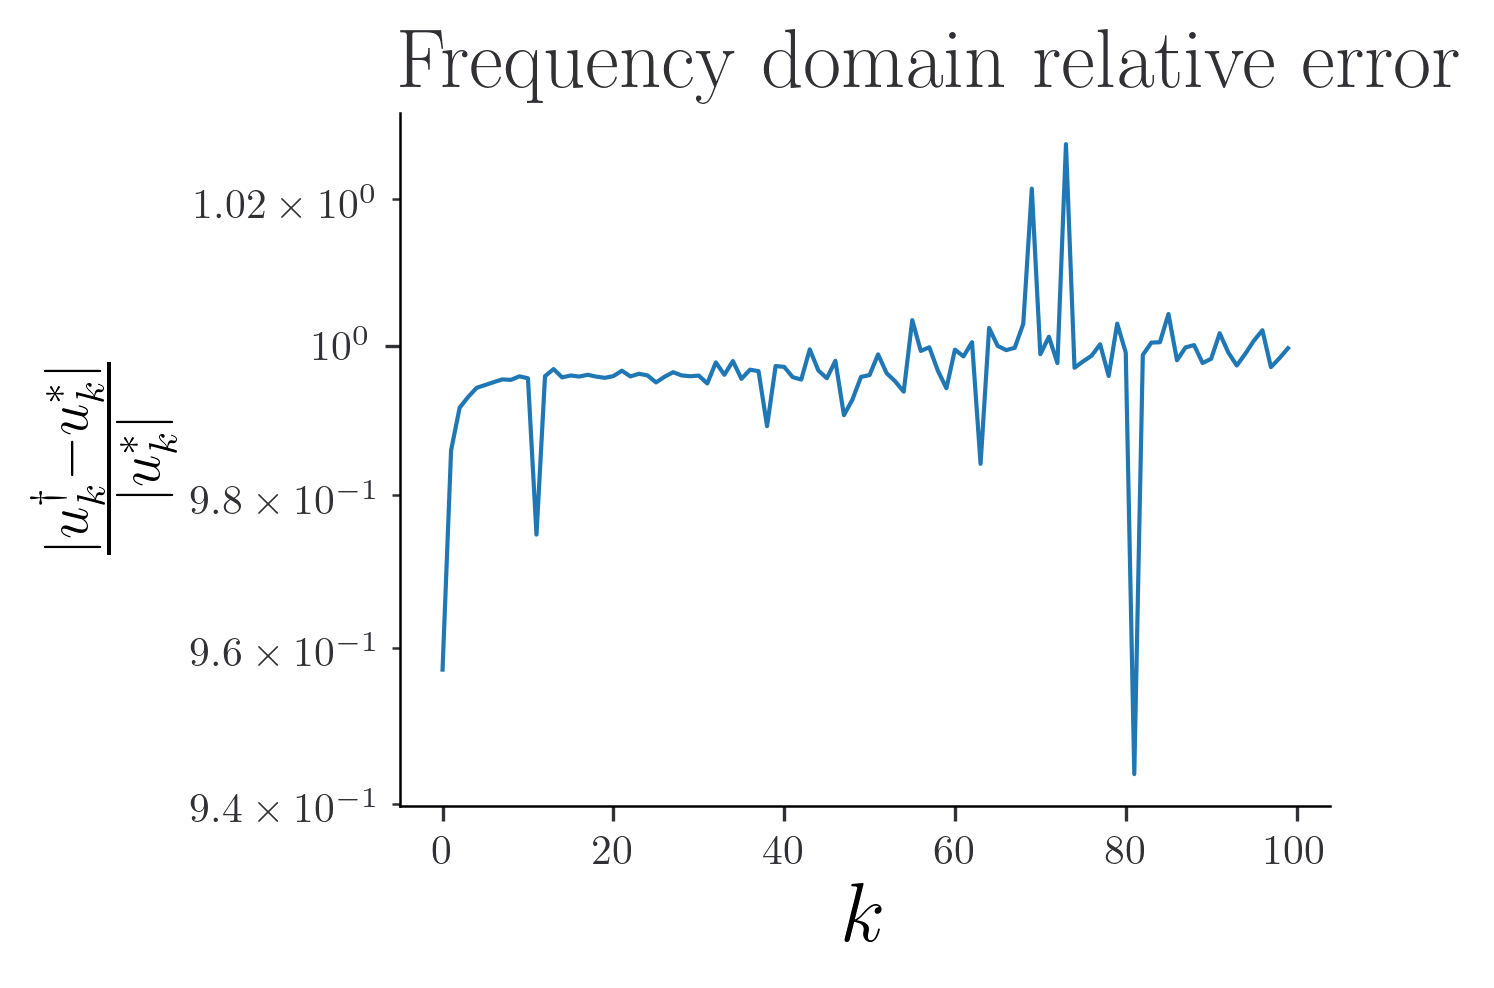

In [144]:
figure = plt.figure(figsize=(width, height))
plt.plot(error_freq_rel[:100])
plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\frac{|{u}^\dagger_k - u^*_k|}{|u^*_k|}$")
plt.title(r"Frequency domain relative error")
plt.show()